In [14]:
import gym
import gym_foa
from gym import wrappers

ENV_NAME = 'foa-v0'
env = gym.make(ENV_NAME)


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import copy
import time
import os

[2017-09-25 16:02:15,826] Making new env: foa-v0


In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
env = wrappers.Monitor(env, '1024+1024_512_256,1024_1024_512_256', force=True)
TAU = .01
GAMMA = .9
LR_actor = .001
LR_critic = .001
EXPERIENCE_CAPACITY = 7000
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = int(1e5)
MAX_STEP = 100
BATCH_SIZE = 32
#EPSILON = .1
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]
N_UAVS = 1

[2017-09-25 16:02:15,848] Clearing 6 monitor files from previous run (because force=True was provided)


In [16]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [17]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
        #return self.mem[:1]
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 150)
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 150)
        self.fcA.weight.data.normal_(0, 0.1)
        self.fc1 = nn.Linear(150, 100)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(100, 100)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(100, 1)
        self.fc3.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        a = self.fcA(y)
        o = F.relu(s+a)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)
        o = F.relu(o)
        o = self.fc3(o)
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES/N_UAVS, 150)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(150, 100)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(100, 100)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(100, N_ACTIONS/N_UAVS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [18]:
def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    
    
    
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    bat_a0_ = target_actor(bat_o_[:,:N_STATES/N_UAVS])
    #bat_a1_ = target_actor(bat_o_[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2_ = target_actor(bat_o_[:,-N_STATES/N_UAVS:])
    #bat_a_o_ = torch.cat([bat_a0_, bat_a1_, bat_a2_], dim=1)
    bat_a_o_ = bat_a0_

    Gt = bat_r + GAMMA * target_critic(bat_o_, bat_a_o_)
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    bat_a0 = actor(bat_o[:,:N_STATES/N_UAVS])
    #bat_a1 = actor(bat_o[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2 = actor(bat_o[:,-N_STATES/N_UAVS:])
    #bat_a_o = torch.cat([bat_a0, bat_a1, bat_a2], dim=1)
    bat_a_o = bat_a0
    
    obj = torch.mean(critic(bat_o, bat_a_o))
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()    

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def soft_update(target, behavior, tau):
    for key in target.state_dict().keys():
        target.state_dict()[key].copy_(tau * behavior.state_dict()[key] + (1-tau) * target.state_dict()[key])

In [19]:
start_time = time.time()

n_vec_r = []
n_vec_cost = []
for n in xrange(1):    
    target_actor = Actor()
    target_critic = Critic()
    actor = Actor()
    critic = Critic()
    if use_cuda:
        target_actor.cuda()
        target_critic.cuda()
        actor.cuda()
        critic.cuda()
    exp = Experience(EXPERIENCE_CAPACITY)
    optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    vec_r = []
    vec_cost = []
    update_counter = 0
    for epi in xrange(MAX_EPI):
        if epi%10==0:
            print 'n:{}, epi:{}'.format(n, epi)
            
        o = env.reset()
        acc_r = 0
        
        local_r = []
        
        avg_cost = np.zeros([4])
    
        counter = 0
        #for t in xrange(MAX_STEP):    
        while True:
            counter += 1
            
            env.render()
            
            a0 = choose_action(o[:N_STATES/N_UAVS], actor)
            #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
            #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
            #a = np.hstack([a0, a1, a2])
            a = a0
            #print a
            #a = np.array([0,1,0,1,0,1])
            
            o_, r, done, info = env.step(a)
            exp.push(o, a, r, o_)
            
            cost = np.array(info['cost'])
            avg_cost += (cost-avg_cost)/(counter)
            #print cost
            #print o
            #print avg_cost
            
            #torch.cuda.synchronize()
            #start_time = time.time()
            
            update_actor_critic(target_actor, target_critic, \
                               actor, critic, exp, optim_actor, optim_critic)
            update_counter += 1
            
            #torch.cuda.synchronize()
            #print("--- %s seconds ---" % (time.time() - start_time))  
            
            if update_counter % TARGET_UPDATE_FREQUENCY == 0:
                update_target(target_actor, target_critic, \
                             actor, critic)
            
            local_r.append(r)
            acc_r += r
            o = o_
            if done:
                break
        
        #print counter

#         if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
#             plt.plot(xrange(len(local_r)), local_r)
#             plt.title('n: {}, epi: {}'.format(n, epi))
#             plt.show()
    
        vec_r.append(acc_r)
        vec_cost.append(avg_cost)
        
    n_vec_r.append(vec_r)
    n_vec_cost.append(vec_cost)
    torch.save(actor.state_dict(), 'actor{}.pt'.format(n))

print("--- %s seconds ---" % (time.time() - start_time))



[2017-09-25 16:02:16,121] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000000.mp4


n:0, epi:0


[2017-09-25 16:02:16,867] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000001.mp4
[2017-09-25 16:02:17,784] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000008.mp4


n:0, epi:10
n:0, epi:20


[2017-09-25 16:02:20,105] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000027.mp4


n:0, epi:30
n:0, epi:40
n:0, epi:50
n:0, epi:60


[2017-09-25 16:02:24,156] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000064.mp4


n:0, epi:70
n:0, epi:80
n:0, epi:90
n:0, epi:100
n:0, epi:110
n:0, epi:120


[2017-09-25 16:02:35,858] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000125.mp4


n:0, epi:130
n:0, epi:140
n:0, epi:150
n:0, epi:160
n:0, epi:170
n:0, epi:180
n:0, epi:190
n:0, epi:200
n:0, epi:210


[2017-09-25 16:04:37,242] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000216.mp4


n:0, epi:220
n:0, epi:230
n:0, epi:240
n:0, epi:250
n:0, epi:260
n:0, epi:270
n:0, epi:280
n:0, epi:290
n:0, epi:300
n:0, epi:310
n:0, epi:320
n:0, epi:330
n:0, epi:340


[2017-09-25 16:09:52,359] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000343.mp4


n:0, epi:350
n:0, epi:360
n:0, epi:370
n:0, epi:380
n:0, epi:390
n:0, epi:400
n:0, epi:410
n:0, epi:420
n:0, epi:430
n:0, epi:440
n:0, epi:450
n:0, epi:460
n:0, epi:470
n:0, epi:480
n:0, epi:490
n:0, epi:500
n:0, epi:510


[2017-09-25 16:11:18,177] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000512.mp4


n:0, epi:520
n:0, epi:530
n:0, epi:540
n:0, epi:550
n:0, epi:560
n:0, epi:570
n:0, epi:580
n:0, epi:590
n:0, epi:600
n:0, epi:610
n:0, epi:620
n:0, epi:630
n:0, epi:640
n:0, epi:650
n:0, epi:660
n:0, epi:670
n:0, epi:680
n:0, epi:690
n:0, epi:700
n:0, epi:710
n:0, epi:720


[2017-09-25 16:13:16,838] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video000729.mp4


n:0, epi:730
n:0, epi:740
n:0, epi:750
n:0, epi:760
n:0, epi:770
n:0, epi:780
n:0, epi:790
n:0, epi:800
n:0, epi:810
n:0, epi:820
n:0, epi:830
n:0, epi:840
n:0, epi:850
n:0, epi:860
n:0, epi:870
n:0, epi:880
n:0, epi:890
n:0, epi:900
n:0, epi:910
n:0, epi:920
n:0, epi:930
n:0, epi:940
n:0, epi:950
n:0, epi:960
n:0, epi:970
n:0, epi:980
n:0, epi:990


[2017-09-25 16:15:41,252] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video001000.mp4


n:0, epi:1000
n:0, epi:1010
n:0, epi:1020
n:0, epi:1030
n:0, epi:1040
n:0, epi:1050
n:0, epi:1060
n:0, epi:1070
n:0, epi:1080
n:0, epi:1090
n:0, epi:1100
n:0, epi:1110
n:0, epi:1120
n:0, epi:1130
n:0, epi:1140
n:0, epi:1150
n:0, epi:1160
n:0, epi:1170
n:0, epi:1180
n:0, epi:1190
n:0, epi:1200
n:0, epi:1210
n:0, epi:1220
n:0, epi:1230
n:0, epi:1240
n:0, epi:1250
n:0, epi:1260
n:0, epi:1270
n:0, epi:1280
n:0, epi:1290
n:0, epi:1300
n:0, epi:1310
n:0, epi:1320
n:0, epi:1330
n:0, epi:1340
n:0, epi:1350
n:0, epi:1360
n:0, epi:1370
n:0, epi:1380
n:0, epi:1390
n:0, epi:1400
n:0, epi:1410
n:0, epi:1420
n:0, epi:1430
n:0, epi:1440
n:0, epi:1450
n:0, epi:1460
n:0, epi:1470
n:0, epi:1480
n:0, epi:1490
n:0, epi:1500
n:0, epi:1510
n:0, epi:1520
n:0, epi:1530
n:0, epi:1540
n:0, epi:1550
n:0, epi:1560
n:0, epi:1570
n:0, epi:1580
n:0, epi:1590
n:0, epi:1600
n:0, epi:1610
n:0, epi:1620
n:0, epi:1630
n:0, epi:1640
n:0, epi:1650
n:0, epi:1660
n:0, epi:1670
n:0, epi:1680
n:0, epi:1690
n:0, epi:1700
n:0, e

[2017-09-25 16:19:29,683] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video002000.mp4


n:0, epi:2000
n:0, epi:2010
n:0, epi:2020
n:0, epi:2030
n:0, epi:2040
n:0, epi:2050
n:0, epi:2060
n:0, epi:2070
n:0, epi:2080
n:0, epi:2090
n:0, epi:2100
n:0, epi:2110
n:0, epi:2120
n:0, epi:2130
n:0, epi:2140
n:0, epi:2150
n:0, epi:2160
n:0, epi:2170
n:0, epi:2180
n:0, epi:2190
n:0, epi:2200
n:0, epi:2210
n:0, epi:2220
n:0, epi:2230
n:0, epi:2240
n:0, epi:2250
n:0, epi:2260
n:0, epi:2270
n:0, epi:2280
n:0, epi:2290
n:0, epi:2300
n:0, epi:2310
n:0, epi:2320
n:0, epi:2330
n:0, epi:2340
n:0, epi:2350
n:0, epi:2360
n:0, epi:2370
n:0, epi:2380
n:0, epi:2390
n:0, epi:2400
n:0, epi:2410
n:0, epi:2420
n:0, epi:2430
n:0, epi:2440
n:0, epi:2450
n:0, epi:2460
n:0, epi:2470
n:0, epi:2480
n:0, epi:2490
n:0, epi:2500
n:0, epi:2510
n:0, epi:2520
n:0, epi:2530
n:0, epi:2540
n:0, epi:2550
n:0, epi:2560
n:0, epi:2570
n:0, epi:2580
n:0, epi:2590
n:0, epi:2600
n:0, epi:2610
n:0, epi:2620
n:0, epi:2630
n:0, epi:2640
n:0, epi:2650
n:0, epi:2660
n:0, epi:2670
n:0, epi:2680
n:0, epi:2690
n:0, epi:2700
n:0, e

[2017-09-25 16:26:31,988] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video003000.mp4


n:0, epi:3000
n:0, epi:3010
n:0, epi:3020
n:0, epi:3030
n:0, epi:3040
n:0, epi:3050
n:0, epi:3060
n:0, epi:3070
n:0, epi:3080
n:0, epi:3090
n:0, epi:3100
n:0, epi:3110
n:0, epi:3120
n:0, epi:3130
n:0, epi:3140
n:0, epi:3150
n:0, epi:3160
n:0, epi:3170
n:0, epi:3180
n:0, epi:3190
n:0, epi:3200
n:0, epi:3210
n:0, epi:3220
n:0, epi:3230
n:0, epi:3240
n:0, epi:3250
n:0, epi:3260
n:0, epi:3270
n:0, epi:3280
n:0, epi:3290
n:0, epi:3300
n:0, epi:3310
n:0, epi:3320
n:0, epi:3330
n:0, epi:3340
n:0, epi:3350
n:0, epi:3360
n:0, epi:3370
n:0, epi:3380
n:0, epi:3390
n:0, epi:3400
n:0, epi:3410
n:0, epi:3420
n:0, epi:3430
n:0, epi:3440
n:0, epi:3450
n:0, epi:3460
n:0, epi:3470
n:0, epi:3480
n:0, epi:3490
n:0, epi:3500
n:0, epi:3510
n:0, epi:3520
n:0, epi:3530
n:0, epi:3540
n:0, epi:3550
n:0, epi:3560
n:0, epi:3570
n:0, epi:3580
n:0, epi:3590
n:0, epi:3600
n:0, epi:3610
n:0, epi:3620
n:0, epi:3630
n:0, epi:3640
n:0, epi:3650
n:0, epi:3660
n:0, epi:3670
n:0, epi:3680
n:0, epi:3690
n:0, epi:3700
n:0, e

[2017-09-25 16:31:31,627] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video004000.mp4


n:0, epi:4000
n:0, epi:4010
n:0, epi:4020
n:0, epi:4030
n:0, epi:4040
n:0, epi:4050
n:0, epi:4060
n:0, epi:4070
n:0, epi:4080
n:0, epi:4090
n:0, epi:4100
n:0, epi:4110
n:0, epi:4120
n:0, epi:4130
n:0, epi:4140
n:0, epi:4150
n:0, epi:4160
n:0, epi:4170
n:0, epi:4180
n:0, epi:4190
n:0, epi:4200
n:0, epi:4210
n:0, epi:4220
n:0, epi:4230
n:0, epi:4240
n:0, epi:4250
n:0, epi:4260
n:0, epi:4270
n:0, epi:4280
n:0, epi:4290
n:0, epi:4300
n:0, epi:4310
n:0, epi:4320
n:0, epi:4330
n:0, epi:4340
n:0, epi:4350
n:0, epi:4360
n:0, epi:4370
n:0, epi:4380
n:0, epi:4390
n:0, epi:4400
n:0, epi:4410
n:0, epi:4420
n:0, epi:4430
n:0, epi:4440
n:0, epi:4450
n:0, epi:4460
n:0, epi:4470
n:0, epi:4480
n:0, epi:4490
n:0, epi:4500
n:0, epi:4510
n:0, epi:4520
n:0, epi:4530
n:0, epi:4540
n:0, epi:4550
n:0, epi:4560
n:0, epi:4570
n:0, epi:4580
n:0, epi:4590
n:0, epi:4600
n:0, epi:4610
n:0, epi:4620
n:0, epi:4630
n:0, epi:4640
n:0, epi:4650
n:0, epi:4660
n:0, epi:4670
n:0, epi:4680
n:0, epi:4690
n:0, epi:4700
n:0, e

[2017-09-25 16:35:55,787] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video005000.mp4


n:0, epi:5000
n:0, epi:5010
n:0, epi:5020
n:0, epi:5030
n:0, epi:5040
n:0, epi:5050
n:0, epi:5060
n:0, epi:5070
n:0, epi:5080
n:0, epi:5090
n:0, epi:5100
n:0, epi:5110
n:0, epi:5120
n:0, epi:5130
n:0, epi:5140
n:0, epi:5150
n:0, epi:5160
n:0, epi:5170
n:0, epi:5180
n:0, epi:5190
n:0, epi:5200
n:0, epi:5210
n:0, epi:5220
n:0, epi:5230
n:0, epi:5240
n:0, epi:5250
n:0, epi:5260
n:0, epi:5270
n:0, epi:5280
n:0, epi:5290
n:0, epi:5300
n:0, epi:5310
n:0, epi:5320
n:0, epi:5330
n:0, epi:5340
n:0, epi:5350
n:0, epi:5360
n:0, epi:5370
n:0, epi:5380
n:0, epi:5390
n:0, epi:5400
n:0, epi:5410
n:0, epi:5420
n:0, epi:5430
n:0, epi:5440
n:0, epi:5450
n:0, epi:5460
n:0, epi:5470
n:0, epi:5480
n:0, epi:5490
n:0, epi:5500
n:0, epi:5510
n:0, epi:5520
n:0, epi:5530
n:0, epi:5540
n:0, epi:5550
n:0, epi:5560
n:0, epi:5570
n:0, epi:5580
n:0, epi:5590
n:0, epi:5600
n:0, epi:5610
n:0, epi:5620
n:0, epi:5630
n:0, epi:5640
n:0, epi:5650
n:0, epi:5660
n:0, epi:5670
n:0, epi:5680
n:0, epi:5690
n:0, epi:5700
n:0, e

[2017-09-25 16:39:49,586] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video006000.mp4


n:0, epi:6000
n:0, epi:6010
n:0, epi:6020
n:0, epi:6030
n:0, epi:6040
n:0, epi:6050
n:0, epi:6060
n:0, epi:6070
n:0, epi:6080
n:0, epi:6090
n:0, epi:6100
n:0, epi:6110
n:0, epi:6120
n:0, epi:6130
n:0, epi:6140
n:0, epi:6150
n:0, epi:6160
n:0, epi:6170
n:0, epi:6180
n:0, epi:6190
n:0, epi:6200
n:0, epi:6210
n:0, epi:6220
n:0, epi:6230
n:0, epi:6240
n:0, epi:6250
n:0, epi:6260
n:0, epi:6270
n:0, epi:6280
n:0, epi:6290
n:0, epi:6300
n:0, epi:6310
n:0, epi:6320
n:0, epi:6330
n:0, epi:6340
n:0, epi:6350
n:0, epi:6360
n:0, epi:6370
n:0, epi:6380
n:0, epi:6390
n:0, epi:6400
n:0, epi:6410
n:0, epi:6420
n:0, epi:6430
n:0, epi:6440
n:0, epi:6450
n:0, epi:6460
n:0, epi:6470
n:0, epi:6480
n:0, epi:6490
n:0, epi:6500
n:0, epi:6510
n:0, epi:6520
n:0, epi:6530
n:0, epi:6540
n:0, epi:6550
n:0, epi:6560
n:0, epi:6570
n:0, epi:6580
n:0, epi:6590
n:0, epi:6600
n:0, epi:6610
n:0, epi:6620
n:0, epi:6630
n:0, epi:6640
n:0, epi:6650
n:0, epi:6660
n:0, epi:6670
n:0, epi:6680
n:0, epi:6690
n:0, epi:6700
n:0, e

[2017-09-25 16:43:35,400] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video007000.mp4


n:0, epi:7000
n:0, epi:7010
n:0, epi:7020
n:0, epi:7030
n:0, epi:7040
n:0, epi:7050
n:0, epi:7060
n:0, epi:7070
n:0, epi:7080
n:0, epi:7090
n:0, epi:7100
n:0, epi:7110
n:0, epi:7120
n:0, epi:7130
n:0, epi:7140
n:0, epi:7150
n:0, epi:7160
n:0, epi:7170
n:0, epi:7180
n:0, epi:7190
n:0, epi:7200
n:0, epi:7210
n:0, epi:7220
n:0, epi:7230
n:0, epi:7240
n:0, epi:7250
n:0, epi:7260
n:0, epi:7270
n:0, epi:7280
n:0, epi:7290
n:0, epi:7300
n:0, epi:7310
n:0, epi:7320
n:0, epi:7330
n:0, epi:7340
n:0, epi:7350
n:0, epi:7360
n:0, epi:7370
n:0, epi:7380
n:0, epi:7390
n:0, epi:7400
n:0, epi:7410
n:0, epi:7420
n:0, epi:7430
n:0, epi:7440
n:0, epi:7450
n:0, epi:7460
n:0, epi:7470
n:0, epi:7480
n:0, epi:7490
n:0, epi:7500
n:0, epi:7510
n:0, epi:7520
n:0, epi:7530
n:0, epi:7540
n:0, epi:7550
n:0, epi:7560
n:0, epi:7570
n:0, epi:7580
n:0, epi:7590
n:0, epi:7600
n:0, epi:7610
n:0, epi:7620
n:0, epi:7630
n:0, epi:7640
n:0, epi:7650
n:0, epi:7660
n:0, epi:7670
n:0, epi:7680
n:0, epi:7690
n:0, epi:7700
n:0, e

[2017-09-25 16:47:26,556] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video008000.mp4


n:0, epi:8000
n:0, epi:8010
n:0, epi:8020
n:0, epi:8030
n:0, epi:8040
n:0, epi:8050
n:0, epi:8060
n:0, epi:8070
n:0, epi:8080
n:0, epi:8090
n:0, epi:8100
n:0, epi:8110
n:0, epi:8120
n:0, epi:8130
n:0, epi:8140
n:0, epi:8150
n:0, epi:8160
n:0, epi:8170
n:0, epi:8180
n:0, epi:8190
n:0, epi:8200
n:0, epi:8210
n:0, epi:8220
n:0, epi:8230
n:0, epi:8240
n:0, epi:8250
n:0, epi:8260
n:0, epi:8270
n:0, epi:8280
n:0, epi:8290
n:0, epi:8300
n:0, epi:8310
n:0, epi:8320
n:0, epi:8330
n:0, epi:8340
n:0, epi:8350
n:0, epi:8360
n:0, epi:8370
n:0, epi:8380
n:0, epi:8390
n:0, epi:8400
n:0, epi:8410
n:0, epi:8420
n:0, epi:8430
n:0, epi:8440
n:0, epi:8450
n:0, epi:8460
n:0, epi:8470
n:0, epi:8480
n:0, epi:8490
n:0, epi:8500
n:0, epi:8510
n:0, epi:8520
n:0, epi:8530
n:0, epi:8540
n:0, epi:8550
n:0, epi:8560
n:0, epi:8570
n:0, epi:8580
n:0, epi:8590
n:0, epi:8600
n:0, epi:8610
n:0, epi:8620
n:0, epi:8630
n:0, epi:8640
n:0, epi:8650
n:0, epi:8660
n:0, epi:8670
n:0, epi:8680
n:0, epi:8690
n:0, epi:8700
n:0, e

[2017-09-25 16:50:04,750] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video009000.mp4


n:0, epi:9000
n:0, epi:9010
n:0, epi:9020
n:0, epi:9030
n:0, epi:9040
n:0, epi:9050
n:0, epi:9060
n:0, epi:9070
n:0, epi:9080
n:0, epi:9090
n:0, epi:9100
n:0, epi:9110
n:0, epi:9120
n:0, epi:9130
n:0, epi:9140
n:0, epi:9150
n:0, epi:9160
n:0, epi:9170
n:0, epi:9180
n:0, epi:9190
n:0, epi:9200
n:0, epi:9210
n:0, epi:9220
n:0, epi:9230
n:0, epi:9240
n:0, epi:9250
n:0, epi:9260
n:0, epi:9270
n:0, epi:9280
n:0, epi:9290
n:0, epi:9300
n:0, epi:9310
n:0, epi:9320
n:0, epi:9330
n:0, epi:9340
n:0, epi:9350
n:0, epi:9360
n:0, epi:9370
n:0, epi:9380
n:0, epi:9390
n:0, epi:9400
n:0, epi:9410
n:0, epi:9420
n:0, epi:9430
n:0, epi:9440
n:0, epi:9450
n:0, epi:9460
n:0, epi:9470
n:0, epi:9480
n:0, epi:9490
n:0, epi:9500
n:0, epi:9510
n:0, epi:9520
n:0, epi:9530
n:0, epi:9540
n:0, epi:9550
n:0, epi:9560
n:0, epi:9570
n:0, epi:9580
n:0, epi:9590
n:0, epi:9600
n:0, epi:9610
n:0, epi:9620
n:0, epi:9630
n:0, epi:9640
n:0, epi:9650
n:0, epi:9660
n:0, epi:9670
n:0, epi:9680
n:0, epi:9690
n:0, epi:9700
n:0, e

[2017-09-25 16:55:18,284] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video010000.mp4


n:0, epi:10000
n:0, epi:10010
n:0, epi:10020
n:0, epi:10030
n:0, epi:10040
n:0, epi:10050
n:0, epi:10060
n:0, epi:10070
n:0, epi:10080
n:0, epi:10090
n:0, epi:10100
n:0, epi:10110
n:0, epi:10120
n:0, epi:10130
n:0, epi:10140
n:0, epi:10150
n:0, epi:10160
n:0, epi:10170
n:0, epi:10180
n:0, epi:10190
n:0, epi:10200
n:0, epi:10210
n:0, epi:10220
n:0, epi:10230
n:0, epi:10240
n:0, epi:10250
n:0, epi:10260
n:0, epi:10270
n:0, epi:10280
n:0, epi:10290
n:0, epi:10300
n:0, epi:10310
n:0, epi:10320
n:0, epi:10330
n:0, epi:10340
n:0, epi:10350
n:0, epi:10360
n:0, epi:10370
n:0, epi:10380
n:0, epi:10390
n:0, epi:10400
n:0, epi:10410
n:0, epi:10420
n:0, epi:10430
n:0, epi:10440
n:0, epi:10450
n:0, epi:10460
n:0, epi:10470
n:0, epi:10480
n:0, epi:10490
n:0, epi:10500
n:0, epi:10510
n:0, epi:10520
n:0, epi:10530
n:0, epi:10540
n:0, epi:10550
n:0, epi:10560
n:0, epi:10570
n:0, epi:10580
n:0, epi:10590
n:0, epi:10600
n:0, epi:10610
n:0, epi:10620
n:0, epi:10630
n:0, epi:10640
n:0, epi:10650
n:0, epi:1

[2017-09-25 16:58:59,293] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video011000.mp4


n:0, epi:11000
n:0, epi:11010
n:0, epi:11020
n:0, epi:11030
n:0, epi:11040
n:0, epi:11050
n:0, epi:11060
n:0, epi:11070
n:0, epi:11080
n:0, epi:11090
n:0, epi:11100
n:0, epi:11110
n:0, epi:11120
n:0, epi:11130
n:0, epi:11140
n:0, epi:11150
n:0, epi:11160
n:0, epi:11170
n:0, epi:11180
n:0, epi:11190
n:0, epi:11200
n:0, epi:11210
n:0, epi:11220
n:0, epi:11230
n:0, epi:11240
n:0, epi:11250
n:0, epi:11260
n:0, epi:11270
n:0, epi:11280
n:0, epi:11290
n:0, epi:11300
n:0, epi:11310
n:0, epi:11320
n:0, epi:11330
n:0, epi:11340
n:0, epi:11350
n:0, epi:11360
n:0, epi:11370
n:0, epi:11380
n:0, epi:11390
n:0, epi:11400
n:0, epi:11410
n:0, epi:11420
n:0, epi:11430
n:0, epi:11440
n:0, epi:11450
n:0, epi:11460
n:0, epi:11470
n:0, epi:11480
n:0, epi:11490
n:0, epi:11500
n:0, epi:11510
n:0, epi:11520
n:0, epi:11530
n:0, epi:11540
n:0, epi:11550
n:0, epi:11560
n:0, epi:11570
n:0, epi:11580
n:0, epi:11590
n:0, epi:11600
n:0, epi:11610
n:0, epi:11620
n:0, epi:11630
n:0, epi:11640
n:0, epi:11650
n:0, epi:1

[2017-09-25 17:00:21,008] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video012000.mp4


n:0, epi:12000
n:0, epi:12010
n:0, epi:12020
n:0, epi:12030
n:0, epi:12040
n:0, epi:12050
n:0, epi:12060
n:0, epi:12070
n:0, epi:12080
n:0, epi:12090
n:0, epi:12100
n:0, epi:12110
n:0, epi:12120
n:0, epi:12130
n:0, epi:12140
n:0, epi:12150
n:0, epi:12160
n:0, epi:12170
n:0, epi:12180
n:0, epi:12190
n:0, epi:12200
n:0, epi:12210
n:0, epi:12220
n:0, epi:12230
n:0, epi:12240
n:0, epi:12250
n:0, epi:12260
n:0, epi:12270
n:0, epi:12280
n:0, epi:12290
n:0, epi:12300
n:0, epi:12310
n:0, epi:12320
n:0, epi:12330
n:0, epi:12340
n:0, epi:12350
n:0, epi:12360
n:0, epi:12370
n:0, epi:12380
n:0, epi:12390
n:0, epi:12400
n:0, epi:12410
n:0, epi:12420
n:0, epi:12430
n:0, epi:12440
n:0, epi:12450
n:0, epi:12460
n:0, epi:12470
n:0, epi:12480
n:0, epi:12490
n:0, epi:12500
n:0, epi:12510
n:0, epi:12520
n:0, epi:12530
n:0, epi:12540
n:0, epi:12550
n:0, epi:12560
n:0, epi:12570
n:0, epi:12580
n:0, epi:12590
n:0, epi:12600
n:0, epi:12610
n:0, epi:12620
n:0, epi:12630
n:0, epi:12640
n:0, epi:12650
n:0, epi:1

[2017-09-25 17:04:09,146] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video013000.mp4


n:0, epi:13000
n:0, epi:13010
n:0, epi:13020
n:0, epi:13030
n:0, epi:13040
n:0, epi:13050
n:0, epi:13060
n:0, epi:13070
n:0, epi:13080
n:0, epi:13090
n:0, epi:13100
n:0, epi:13110
n:0, epi:13120
n:0, epi:13130
n:0, epi:13140
n:0, epi:13150
n:0, epi:13160
n:0, epi:13170
n:0, epi:13180
n:0, epi:13190
n:0, epi:13200
n:0, epi:13210
n:0, epi:13220
n:0, epi:13230
n:0, epi:13240
n:0, epi:13250
n:0, epi:13260
n:0, epi:13270
n:0, epi:13280
n:0, epi:13290
n:0, epi:13300
n:0, epi:13310
n:0, epi:13320
n:0, epi:13330
n:0, epi:13340
n:0, epi:13350
n:0, epi:13360
n:0, epi:13370
n:0, epi:13380
n:0, epi:13390
n:0, epi:13400
n:0, epi:13410
n:0, epi:13420
n:0, epi:13430
n:0, epi:13440
n:0, epi:13450
n:0, epi:13460
n:0, epi:13470
n:0, epi:13480
n:0, epi:13490
n:0, epi:13500
n:0, epi:13510
n:0, epi:13520
n:0, epi:13530
n:0, epi:13540
n:0, epi:13550
n:0, epi:13560
n:0, epi:13570
n:0, epi:13580
n:0, epi:13590
n:0, epi:13600
n:0, epi:13610
n:0, epi:13620
n:0, epi:13630
n:0, epi:13640
n:0, epi:13650
n:0, epi:1

[2017-09-25 17:08:01,210] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video014000.mp4


n:0, epi:14000
n:0, epi:14010
n:0, epi:14020
n:0, epi:14030
n:0, epi:14040
n:0, epi:14050
n:0, epi:14060
n:0, epi:14070
n:0, epi:14080
n:0, epi:14090
n:0, epi:14100
n:0, epi:14110
n:0, epi:14120
n:0, epi:14130
n:0, epi:14140
n:0, epi:14150
n:0, epi:14160
n:0, epi:14170
n:0, epi:14180
n:0, epi:14190
n:0, epi:14200
n:0, epi:14210
n:0, epi:14220
n:0, epi:14230
n:0, epi:14240
n:0, epi:14250
n:0, epi:14260
n:0, epi:14270
n:0, epi:14280
n:0, epi:14290
n:0, epi:14300
n:0, epi:14310
n:0, epi:14320
n:0, epi:14330
n:0, epi:14340
n:0, epi:14350
n:0, epi:14360
n:0, epi:14370
n:0, epi:14380
n:0, epi:14390
n:0, epi:14400
n:0, epi:14410
n:0, epi:14420
n:0, epi:14430
n:0, epi:14440
n:0, epi:14450
n:0, epi:14460
n:0, epi:14470
n:0, epi:14480
n:0, epi:14490
n:0, epi:14500
n:0, epi:14510
n:0, epi:14520
n:0, epi:14530
n:0, epi:14540
n:0, epi:14550
n:0, epi:14560
n:0, epi:14570
n:0, epi:14580
n:0, epi:14590
n:0, epi:14600
n:0, epi:14610
n:0, epi:14620
n:0, epi:14630
n:0, epi:14640
n:0, epi:14650
n:0, epi:1

[2017-09-25 17:13:43,056] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video015000.mp4


n:0, epi:15000
n:0, epi:15010
n:0, epi:15020
n:0, epi:15030
n:0, epi:15040
n:0, epi:15050
n:0, epi:15060
n:0, epi:15070
n:0, epi:15080
n:0, epi:15090
n:0, epi:15100
n:0, epi:15110
n:0, epi:15120
n:0, epi:15130
n:0, epi:15140
n:0, epi:15150
n:0, epi:15160
n:0, epi:15170
n:0, epi:15180
n:0, epi:15190
n:0, epi:15200
n:0, epi:15210
n:0, epi:15220
n:0, epi:15230
n:0, epi:15240
n:0, epi:15250
n:0, epi:15260
n:0, epi:15270
n:0, epi:15280
n:0, epi:15290
n:0, epi:15300
n:0, epi:15310
n:0, epi:15320
n:0, epi:15330
n:0, epi:15340
n:0, epi:15350
n:0, epi:15360
n:0, epi:15370
n:0, epi:15380
n:0, epi:15390
n:0, epi:15400
n:0, epi:15410
n:0, epi:15420
n:0, epi:15430
n:0, epi:15440
n:0, epi:15450
n:0, epi:15460
n:0, epi:15470
n:0, epi:15480
n:0, epi:15490
n:0, epi:15500
n:0, epi:15510
n:0, epi:15520
n:0, epi:15530
n:0, epi:15540
n:0, epi:15550
n:0, epi:15560
n:0, epi:15570
n:0, epi:15580
n:0, epi:15590
n:0, epi:15600
n:0, epi:15610
n:0, epi:15620
n:0, epi:15630
n:0, epi:15640
n:0, epi:15650
n:0, epi:1

[2017-09-25 17:28:13,117] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video016000.mp4


n:0, epi:16000
n:0, epi:16010
n:0, epi:16020
n:0, epi:16030
n:0, epi:16040
n:0, epi:16050
n:0, epi:16060
n:0, epi:16070
n:0, epi:16080
n:0, epi:16090
n:0, epi:16100
n:0, epi:16110
n:0, epi:16120
n:0, epi:16130
n:0, epi:16140
n:0, epi:16150
n:0, epi:16160
n:0, epi:16170
n:0, epi:16180
n:0, epi:16190
n:0, epi:16200
n:0, epi:16210
n:0, epi:16220
n:0, epi:16230
n:0, epi:16240
n:0, epi:16250
n:0, epi:16260
n:0, epi:16270
n:0, epi:16280
n:0, epi:16290
n:0, epi:16300
n:0, epi:16310
n:0, epi:16320
n:0, epi:16330
n:0, epi:16340
n:0, epi:16350
n:0, epi:16360
n:0, epi:16370
n:0, epi:16380
n:0, epi:16390
n:0, epi:16400
n:0, epi:16410
n:0, epi:16420
n:0, epi:16430
n:0, epi:16440
n:0, epi:16450
n:0, epi:16460
n:0, epi:16470
n:0, epi:16480
n:0, epi:16490
n:0, epi:16500
n:0, epi:16510
n:0, epi:16520
n:0, epi:16530
n:0, epi:16540
n:0, epi:16550
n:0, epi:16560
n:0, epi:16570
n:0, epi:16580
n:0, epi:16590
n:0, epi:16600
n:0, epi:16610
n:0, epi:16620
n:0, epi:16630
n:0, epi:16640
n:0, epi:16650
n:0, epi:1

[2017-09-25 17:28:49,505] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video017000.mp4


n:0, epi:17000
n:0, epi:17010
n:0, epi:17020
n:0, epi:17030
n:0, epi:17040
n:0, epi:17050
n:0, epi:17060
n:0, epi:17070
n:0, epi:17080
n:0, epi:17090
n:0, epi:17100
n:0, epi:17110
n:0, epi:17120
n:0, epi:17130
n:0, epi:17140
n:0, epi:17150
n:0, epi:17160
n:0, epi:17170
n:0, epi:17180
n:0, epi:17190
n:0, epi:17200
n:0, epi:17210
n:0, epi:17220
n:0, epi:17230
n:0, epi:17240
n:0, epi:17250
n:0, epi:17260
n:0, epi:17270
n:0, epi:17280
n:0, epi:17290
n:0, epi:17300
n:0, epi:17310
n:0, epi:17320
n:0, epi:17330
n:0, epi:17340
n:0, epi:17350
n:0, epi:17360
n:0, epi:17370
n:0, epi:17380
n:0, epi:17390
n:0, epi:17400
n:0, epi:17410
n:0, epi:17420
n:0, epi:17430
n:0, epi:17440
n:0, epi:17450
n:0, epi:17460
n:0, epi:17470
n:0, epi:17480
n:0, epi:17490
n:0, epi:17500
n:0, epi:17510
n:0, epi:17520
n:0, epi:17530
n:0, epi:17540
n:0, epi:17550
n:0, epi:17560
n:0, epi:17570
n:0, epi:17580
n:0, epi:17590
n:0, epi:17600
n:0, epi:17610
n:0, epi:17620
n:0, epi:17630
n:0, epi:17640
n:0, epi:17650
n:0, epi:1

[2017-09-25 17:29:28,594] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video018000.mp4


n:0, epi:18000
n:0, epi:18010
n:0, epi:18020
n:0, epi:18030
n:0, epi:18040
n:0, epi:18050
n:0, epi:18060
n:0, epi:18070
n:0, epi:18080
n:0, epi:18090
n:0, epi:18100
n:0, epi:18110
n:0, epi:18120
n:0, epi:18130
n:0, epi:18140
n:0, epi:18150
n:0, epi:18160
n:0, epi:18170
n:0, epi:18180
n:0, epi:18190
n:0, epi:18200
n:0, epi:18210
n:0, epi:18220
n:0, epi:18230
n:0, epi:18240
n:0, epi:18250
n:0, epi:18260
n:0, epi:18270
n:0, epi:18280
n:0, epi:18290
n:0, epi:18300
n:0, epi:18310
n:0, epi:18320
n:0, epi:18330
n:0, epi:18340
n:0, epi:18350
n:0, epi:18360
n:0, epi:18370
n:0, epi:18380
n:0, epi:18390
n:0, epi:18400
n:0, epi:18410
n:0, epi:18420
n:0, epi:18430
n:0, epi:18440
n:0, epi:18450
n:0, epi:18460
n:0, epi:18470
n:0, epi:18480
n:0, epi:18490
n:0, epi:18500
n:0, epi:18510
n:0, epi:18520
n:0, epi:18530
n:0, epi:18540
n:0, epi:18550
n:0, epi:18560
n:0, epi:18570
n:0, epi:18580
n:0, epi:18590
n:0, epi:18600
n:0, epi:18610
n:0, epi:18620
n:0, epi:18630
n:0, epi:18640
n:0, epi:18650
n:0, epi:1

[2017-09-25 17:30:37,701] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video019000.mp4


n:0, epi:19000
n:0, epi:19010
n:0, epi:19020
n:0, epi:19030
n:0, epi:19040
n:0, epi:19050
n:0, epi:19060
n:0, epi:19070
n:0, epi:19080
n:0, epi:19090
n:0, epi:19100
n:0, epi:19110
n:0, epi:19120
n:0, epi:19130
n:0, epi:19140
n:0, epi:19150
n:0, epi:19160
n:0, epi:19170
n:0, epi:19180
n:0, epi:19190
n:0, epi:19200
n:0, epi:19210
n:0, epi:19220
n:0, epi:19230
n:0, epi:19240
n:0, epi:19250
n:0, epi:19260
n:0, epi:19270
n:0, epi:19280
n:0, epi:19290
n:0, epi:19300
n:0, epi:19310
n:0, epi:19320
n:0, epi:19330
n:0, epi:19340
n:0, epi:19350
n:0, epi:19360
n:0, epi:19370
n:0, epi:19380
n:0, epi:19390
n:0, epi:19400
n:0, epi:19410
n:0, epi:19420
n:0, epi:19430
n:0, epi:19440
n:0, epi:19450
n:0, epi:19460
n:0, epi:19470
n:0, epi:19480
n:0, epi:19490
n:0, epi:19500
n:0, epi:19510
n:0, epi:19520
n:0, epi:19530
n:0, epi:19540
n:0, epi:19550
n:0, epi:19560
n:0, epi:19570
n:0, epi:19580
n:0, epi:19590
n:0, epi:19600
n:0, epi:19610
n:0, epi:19620
n:0, epi:19630
n:0, epi:19640
n:0, epi:19650
n:0, epi:1

[2017-09-25 17:31:55,696] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video020000.mp4


n:0, epi:20000
n:0, epi:20010
n:0, epi:20020
n:0, epi:20030
n:0, epi:20040
n:0, epi:20050
n:0, epi:20060
n:0, epi:20070
n:0, epi:20080
n:0, epi:20090
n:0, epi:20100
n:0, epi:20110
n:0, epi:20120
n:0, epi:20130
n:0, epi:20140
n:0, epi:20150
n:0, epi:20160
n:0, epi:20170
n:0, epi:20180
n:0, epi:20190
n:0, epi:20200
n:0, epi:20210
n:0, epi:20220
n:0, epi:20230
n:0, epi:20240
n:0, epi:20250
n:0, epi:20260
n:0, epi:20270
n:0, epi:20280
n:0, epi:20290
n:0, epi:20300
n:0, epi:20310
n:0, epi:20320
n:0, epi:20330
n:0, epi:20340
n:0, epi:20350
n:0, epi:20360
n:0, epi:20370
n:0, epi:20380
n:0, epi:20390
n:0, epi:20400
n:0, epi:20410
n:0, epi:20420
n:0, epi:20430
n:0, epi:20440
n:0, epi:20450
n:0, epi:20460
n:0, epi:20470
n:0, epi:20480
n:0, epi:20490
n:0, epi:20500
n:0, epi:20510
n:0, epi:20520
n:0, epi:20530
n:0, epi:20540
n:0, epi:20550
n:0, epi:20560
n:0, epi:20570
n:0, epi:20580
n:0, epi:20590
n:0, epi:20600
n:0, epi:20610
n:0, epi:20620
n:0, epi:20630
n:0, epi:20640
n:0, epi:20650
n:0, epi:2

[2017-09-25 17:33:09,537] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video021000.mp4


n:0, epi:21000
n:0, epi:21010
n:0, epi:21020
n:0, epi:21030
n:0, epi:21040
n:0, epi:21050
n:0, epi:21060
n:0, epi:21070
n:0, epi:21080
n:0, epi:21090
n:0, epi:21100
n:0, epi:21110
n:0, epi:21120
n:0, epi:21130
n:0, epi:21140
n:0, epi:21150
n:0, epi:21160
n:0, epi:21170
n:0, epi:21180
n:0, epi:21190
n:0, epi:21200
n:0, epi:21210
n:0, epi:21220
n:0, epi:21230
n:0, epi:21240
n:0, epi:21250
n:0, epi:21260
n:0, epi:21270
n:0, epi:21280
n:0, epi:21290
n:0, epi:21300
n:0, epi:21310
n:0, epi:21320
n:0, epi:21330
n:0, epi:21340
n:0, epi:21350
n:0, epi:21360
n:0, epi:21370
n:0, epi:21380
n:0, epi:21390
n:0, epi:21400
n:0, epi:21410
n:0, epi:21420
n:0, epi:21430
n:0, epi:21440
n:0, epi:21450
n:0, epi:21460
n:0, epi:21470
n:0, epi:21480
n:0, epi:21490
n:0, epi:21500
n:0, epi:21510
n:0, epi:21520
n:0, epi:21530
n:0, epi:21540
n:0, epi:21550
n:0, epi:21560
n:0, epi:21570
n:0, epi:21580
n:0, epi:21590
n:0, epi:21600
n:0, epi:21610
n:0, epi:21620
n:0, epi:21630
n:0, epi:21640
n:0, epi:21650
n:0, epi:2

[2017-09-25 17:34:24,717] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video022000.mp4


n:0, epi:22000
n:0, epi:22010
n:0, epi:22020
n:0, epi:22030
n:0, epi:22040
n:0, epi:22050
n:0, epi:22060
n:0, epi:22070
n:0, epi:22080
n:0, epi:22090
n:0, epi:22100
n:0, epi:22110
n:0, epi:22120
n:0, epi:22130
n:0, epi:22140
n:0, epi:22150
n:0, epi:22160
n:0, epi:22170
n:0, epi:22180
n:0, epi:22190
n:0, epi:22200
n:0, epi:22210
n:0, epi:22220
n:0, epi:22230
n:0, epi:22240
n:0, epi:22250
n:0, epi:22260
n:0, epi:22270
n:0, epi:22280
n:0, epi:22290
n:0, epi:22300
n:0, epi:22310
n:0, epi:22320
n:0, epi:22330
n:0, epi:22340
n:0, epi:22350
n:0, epi:22360
n:0, epi:22370
n:0, epi:22380
n:0, epi:22390
n:0, epi:22400
n:0, epi:22410
n:0, epi:22420
n:0, epi:22430
n:0, epi:22440
n:0, epi:22450
n:0, epi:22460
n:0, epi:22470
n:0, epi:22480
n:0, epi:22490
n:0, epi:22500
n:0, epi:22510
n:0, epi:22520
n:0, epi:22530
n:0, epi:22540
n:0, epi:22550
n:0, epi:22560
n:0, epi:22570
n:0, epi:22580
n:0, epi:22590
n:0, epi:22600
n:0, epi:22610
n:0, epi:22620
n:0, epi:22630
n:0, epi:22640
n:0, epi:22650
n:0, epi:2

[2017-09-25 17:35:44,245] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video023000.mp4


n:0, epi:23000
n:0, epi:23010
n:0, epi:23020
n:0, epi:23030
n:0, epi:23040
n:0, epi:23050
n:0, epi:23060
n:0, epi:23070
n:0, epi:23080
n:0, epi:23090
n:0, epi:23100
n:0, epi:23110
n:0, epi:23120
n:0, epi:23130
n:0, epi:23140
n:0, epi:23150
n:0, epi:23160
n:0, epi:23170
n:0, epi:23180
n:0, epi:23190
n:0, epi:23200
n:0, epi:23210
n:0, epi:23220
n:0, epi:23230
n:0, epi:23240
n:0, epi:23250
n:0, epi:23260
n:0, epi:23270
n:0, epi:23280
n:0, epi:23290
n:0, epi:23300
n:0, epi:23310
n:0, epi:23320
n:0, epi:23330
n:0, epi:23340
n:0, epi:23350
n:0, epi:23360
n:0, epi:23370
n:0, epi:23380
n:0, epi:23390
n:0, epi:23400
n:0, epi:23410
n:0, epi:23420
n:0, epi:23430
n:0, epi:23440
n:0, epi:23450
n:0, epi:23460
n:0, epi:23470
n:0, epi:23480
n:0, epi:23490
n:0, epi:23500
n:0, epi:23510
n:0, epi:23520
n:0, epi:23530
n:0, epi:23540
n:0, epi:23550
n:0, epi:23560
n:0, epi:23570
n:0, epi:23580
n:0, epi:23590
n:0, epi:23600
n:0, epi:23610
n:0, epi:23620
n:0, epi:23630
n:0, epi:23640
n:0, epi:23650
n:0, epi:2

[2017-09-25 17:37:22,306] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video024000.mp4


n:0, epi:24000
n:0, epi:24010
n:0, epi:24020
n:0, epi:24030
n:0, epi:24040
n:0, epi:24050
n:0, epi:24060
n:0, epi:24070
n:0, epi:24080
n:0, epi:24090
n:0, epi:24100
n:0, epi:24110
n:0, epi:24120
n:0, epi:24130
n:0, epi:24140
n:0, epi:24150
n:0, epi:24160
n:0, epi:24170
n:0, epi:24180
n:0, epi:24190
n:0, epi:24200
n:0, epi:24210
n:0, epi:24220
n:0, epi:24230
n:0, epi:24240
n:0, epi:24250
n:0, epi:24260
n:0, epi:24270
n:0, epi:24280
n:0, epi:24290
n:0, epi:24300
n:0, epi:24310
n:0, epi:24320
n:0, epi:24330
n:0, epi:24340
n:0, epi:24350
n:0, epi:24360
n:0, epi:24370
n:0, epi:24380
n:0, epi:24390
n:0, epi:24400
n:0, epi:24410
n:0, epi:24420
n:0, epi:24430
n:0, epi:24440
n:0, epi:24450
n:0, epi:24460
n:0, epi:24470
n:0, epi:24480
n:0, epi:24490
n:0, epi:24500
n:0, epi:24510
n:0, epi:24520
n:0, epi:24530
n:0, epi:24540
n:0, epi:24550
n:0, epi:24560
n:0, epi:24570
n:0, epi:24580
n:0, epi:24590
n:0, epi:24600
n:0, epi:24610
n:0, epi:24620
n:0, epi:24630
n:0, epi:24640
n:0, epi:24650
n:0, epi:2

[2017-09-25 17:38:59,379] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video025000.mp4


n:0, epi:25000
n:0, epi:25010
n:0, epi:25020
n:0, epi:25030
n:0, epi:25040
n:0, epi:25050
n:0, epi:25060
n:0, epi:25070
n:0, epi:25080
n:0, epi:25090
n:0, epi:25100
n:0, epi:25110
n:0, epi:25120
n:0, epi:25130
n:0, epi:25140
n:0, epi:25150
n:0, epi:25160
n:0, epi:25170
n:0, epi:25180
n:0, epi:25190
n:0, epi:25200
n:0, epi:25210
n:0, epi:25220
n:0, epi:25230
n:0, epi:25240
n:0, epi:25250
n:0, epi:25260
n:0, epi:25270
n:0, epi:25280
n:0, epi:25290
n:0, epi:25300
n:0, epi:25310
n:0, epi:25320
n:0, epi:25330
n:0, epi:25340
n:0, epi:25350
n:0, epi:25360
n:0, epi:25370
n:0, epi:25380
n:0, epi:25390
n:0, epi:25400
n:0, epi:25410
n:0, epi:25420
n:0, epi:25430
n:0, epi:25440
n:0, epi:25450
n:0, epi:25460
n:0, epi:25470
n:0, epi:25480
n:0, epi:25490
n:0, epi:25500
n:0, epi:25510
n:0, epi:25520
n:0, epi:25530
n:0, epi:25540
n:0, epi:25550
n:0, epi:25560
n:0, epi:25570
n:0, epi:25580
n:0, epi:25590
n:0, epi:25600
n:0, epi:25610
n:0, epi:25620
n:0, epi:25630
n:0, epi:25640
n:0, epi:25650
n:0, epi:2

[2017-09-25 17:40:55,387] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video026000.mp4


n:0, epi:26000
n:0, epi:26010
n:0, epi:26020
n:0, epi:26030
n:0, epi:26040
n:0, epi:26050
n:0, epi:26060
n:0, epi:26070
n:0, epi:26080
n:0, epi:26090
n:0, epi:26100
n:0, epi:26110
n:0, epi:26120
n:0, epi:26130
n:0, epi:26140
n:0, epi:26150
n:0, epi:26160
n:0, epi:26170
n:0, epi:26180
n:0, epi:26190
n:0, epi:26200
n:0, epi:26210
n:0, epi:26220
n:0, epi:26230
n:0, epi:26240
n:0, epi:26250
n:0, epi:26260
n:0, epi:26270
n:0, epi:26280
n:0, epi:26290
n:0, epi:26300
n:0, epi:26310
n:0, epi:26320
n:0, epi:26330
n:0, epi:26340
n:0, epi:26350
n:0, epi:26360
n:0, epi:26370
n:0, epi:26380
n:0, epi:26390
n:0, epi:26400
n:0, epi:26410
n:0, epi:26420
n:0, epi:26430
n:0, epi:26440
n:0, epi:26450
n:0, epi:26460
n:0, epi:26470
n:0, epi:26480
n:0, epi:26490
n:0, epi:26500
n:0, epi:26510
n:0, epi:26520
n:0, epi:26530
n:0, epi:26540
n:0, epi:26550
n:0, epi:26560
n:0, epi:26570
n:0, epi:26580
n:0, epi:26590
n:0, epi:26600
n:0, epi:26610
n:0, epi:26620
n:0, epi:26630
n:0, epi:26640
n:0, epi:26650
n:0, epi:2

[2017-09-25 17:42:45,033] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video027000.mp4


n:0, epi:27000
n:0, epi:27010
n:0, epi:27020
n:0, epi:27030
n:0, epi:27040
n:0, epi:27050
n:0, epi:27060
n:0, epi:27070
n:0, epi:27080
n:0, epi:27090
n:0, epi:27100
n:0, epi:27110
n:0, epi:27120
n:0, epi:27130
n:0, epi:27140
n:0, epi:27150
n:0, epi:27160
n:0, epi:27170
n:0, epi:27180
n:0, epi:27190
n:0, epi:27200
n:0, epi:27210
n:0, epi:27220
n:0, epi:27230
n:0, epi:27240
n:0, epi:27250
n:0, epi:27260
n:0, epi:27270
n:0, epi:27280
n:0, epi:27290
n:0, epi:27300
n:0, epi:27310
n:0, epi:27320
n:0, epi:27330
n:0, epi:27340
n:0, epi:27350
n:0, epi:27360
n:0, epi:27370
n:0, epi:27380
n:0, epi:27390
n:0, epi:27400
n:0, epi:27410
n:0, epi:27420
n:0, epi:27430
n:0, epi:27440
n:0, epi:27450
n:0, epi:27460
n:0, epi:27470
n:0, epi:27480
n:0, epi:27490
n:0, epi:27500
n:0, epi:27510
n:0, epi:27520
n:0, epi:27530
n:0, epi:27540
n:0, epi:27550
n:0, epi:27560
n:0, epi:27570
n:0, epi:27580
n:0, epi:27590
n:0, epi:27600
n:0, epi:27610
n:0, epi:27620
n:0, epi:27630
n:0, epi:27640
n:0, epi:27650
n:0, epi:2

[2017-09-25 17:44:33,435] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video028000.mp4


n:0, epi:28000
n:0, epi:28010
n:0, epi:28020
n:0, epi:28030
n:0, epi:28040
n:0, epi:28050
n:0, epi:28060
n:0, epi:28070
n:0, epi:28080
n:0, epi:28090
n:0, epi:28100
n:0, epi:28110
n:0, epi:28120
n:0, epi:28130
n:0, epi:28140
n:0, epi:28150
n:0, epi:28160
n:0, epi:28170
n:0, epi:28180
n:0, epi:28190
n:0, epi:28200
n:0, epi:28210
n:0, epi:28220
n:0, epi:28230
n:0, epi:28240
n:0, epi:28250
n:0, epi:28260
n:0, epi:28270
n:0, epi:28280
n:0, epi:28290
n:0, epi:28300
n:0, epi:28310
n:0, epi:28320
n:0, epi:28330
n:0, epi:28340
n:0, epi:28350
n:0, epi:28360
n:0, epi:28370
n:0, epi:28380
n:0, epi:28390
n:0, epi:28400
n:0, epi:28410
n:0, epi:28420
n:0, epi:28430
n:0, epi:28440
n:0, epi:28450
n:0, epi:28460
n:0, epi:28470
n:0, epi:28480
n:0, epi:28490
n:0, epi:28500
n:0, epi:28510
n:0, epi:28520
n:0, epi:28530
n:0, epi:28540
n:0, epi:28550
n:0, epi:28560
n:0, epi:28570
n:0, epi:28580
n:0, epi:28590
n:0, epi:28600
n:0, epi:28610
n:0, epi:28620
n:0, epi:28630
n:0, epi:28640
n:0, epi:28650
n:0, epi:2

[2017-09-25 17:46:07,655] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video029000.mp4


n:0, epi:29000
n:0, epi:29010
n:0, epi:29020
n:0, epi:29030
n:0, epi:29040
n:0, epi:29050
n:0, epi:29060
n:0, epi:29070
n:0, epi:29080
n:0, epi:29090
n:0, epi:29100
n:0, epi:29110
n:0, epi:29120
n:0, epi:29130
n:0, epi:29140
n:0, epi:29150
n:0, epi:29160
n:0, epi:29170
n:0, epi:29180
n:0, epi:29190
n:0, epi:29200
n:0, epi:29210
n:0, epi:29220
n:0, epi:29230
n:0, epi:29240
n:0, epi:29250
n:0, epi:29260
n:0, epi:29270
n:0, epi:29280
n:0, epi:29290
n:0, epi:29300
n:0, epi:29310
n:0, epi:29320
n:0, epi:29330
n:0, epi:29340
n:0, epi:29350
n:0, epi:29360
n:0, epi:29370
n:0, epi:29380
n:0, epi:29390
n:0, epi:29400
n:0, epi:29410
n:0, epi:29420
n:0, epi:29430
n:0, epi:29440
n:0, epi:29450
n:0, epi:29460
n:0, epi:29470
n:0, epi:29480
n:0, epi:29490
n:0, epi:29500
n:0, epi:29510
n:0, epi:29520
n:0, epi:29530
n:0, epi:29540
n:0, epi:29550
n:0, epi:29560
n:0, epi:29570
n:0, epi:29580
n:0, epi:29590
n:0, epi:29600
n:0, epi:29610
n:0, epi:29620
n:0, epi:29630
n:0, epi:29640
n:0, epi:29650
n:0, epi:2

[2017-09-25 17:47:41,618] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video030000.mp4


n:0, epi:30000
n:0, epi:30010
n:0, epi:30020
n:0, epi:30030
n:0, epi:30040
n:0, epi:30050
n:0, epi:30060
n:0, epi:30070
n:0, epi:30080
n:0, epi:30090
n:0, epi:30100
n:0, epi:30110
n:0, epi:30120
n:0, epi:30130
n:0, epi:30140
n:0, epi:30150
n:0, epi:30160
n:0, epi:30170
n:0, epi:30180
n:0, epi:30190
n:0, epi:30200
n:0, epi:30210
n:0, epi:30220
n:0, epi:30230
n:0, epi:30240
n:0, epi:30250
n:0, epi:30260
n:0, epi:30270
n:0, epi:30280
n:0, epi:30290
n:0, epi:30300
n:0, epi:30310
n:0, epi:30320
n:0, epi:30330
n:0, epi:30340
n:0, epi:30350
n:0, epi:30360
n:0, epi:30370
n:0, epi:30380
n:0, epi:30390
n:0, epi:30400
n:0, epi:30410
n:0, epi:30420
n:0, epi:30430
n:0, epi:30440
n:0, epi:30450
n:0, epi:30460
n:0, epi:30470
n:0, epi:30480
n:0, epi:30490
n:0, epi:30500
n:0, epi:30510
n:0, epi:30520
n:0, epi:30530
n:0, epi:30540
n:0, epi:30550
n:0, epi:30560
n:0, epi:30570
n:0, epi:30580
n:0, epi:30590
n:0, epi:30600
n:0, epi:30610
n:0, epi:30620
n:0, epi:30630
n:0, epi:30640
n:0, epi:30650
n:0, epi:3

[2017-09-25 17:49:01,997] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video031000.mp4


n:0, epi:31000
n:0, epi:31010
n:0, epi:31020
n:0, epi:31030
n:0, epi:31040
n:0, epi:31050
n:0, epi:31060
n:0, epi:31070
n:0, epi:31080
n:0, epi:31090
n:0, epi:31100
n:0, epi:31110
n:0, epi:31120
n:0, epi:31130
n:0, epi:31140
n:0, epi:31150
n:0, epi:31160
n:0, epi:31170
n:0, epi:31180
n:0, epi:31190
n:0, epi:31200
n:0, epi:31210
n:0, epi:31220
n:0, epi:31230
n:0, epi:31240
n:0, epi:31250
n:0, epi:31260
n:0, epi:31270
n:0, epi:31280
n:0, epi:31290
n:0, epi:31300
n:0, epi:31310
n:0, epi:31320
n:0, epi:31330
n:0, epi:31340
n:0, epi:31350
n:0, epi:31360
n:0, epi:31370
n:0, epi:31380
n:0, epi:31390
n:0, epi:31400
n:0, epi:31410
n:0, epi:31420
n:0, epi:31430
n:0, epi:31440
n:0, epi:31450
n:0, epi:31460
n:0, epi:31470
n:0, epi:31480
n:0, epi:31490
n:0, epi:31500
n:0, epi:31510
n:0, epi:31520
n:0, epi:31530
n:0, epi:31540
n:0, epi:31550
n:0, epi:31560
n:0, epi:31570
n:0, epi:31580
n:0, epi:31590
n:0, epi:31600
n:0, epi:31610
n:0, epi:31620
n:0, epi:31630
n:0, epi:31640
n:0, epi:31650
n:0, epi:3

[2017-09-25 17:49:48,246] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video032000.mp4


n:0, epi:32000
n:0, epi:32010
n:0, epi:32020
n:0, epi:32030
n:0, epi:32040
n:0, epi:32050
n:0, epi:32060
n:0, epi:32070
n:0, epi:32080
n:0, epi:32090
n:0, epi:32100
n:0, epi:32110
n:0, epi:32120
n:0, epi:32130
n:0, epi:32140
n:0, epi:32150
n:0, epi:32160
n:0, epi:32170
n:0, epi:32180
n:0, epi:32190
n:0, epi:32200
n:0, epi:32210
n:0, epi:32220
n:0, epi:32230
n:0, epi:32240
n:0, epi:32250
n:0, epi:32260
n:0, epi:32270
n:0, epi:32280
n:0, epi:32290
n:0, epi:32300
n:0, epi:32310
n:0, epi:32320
n:0, epi:32330
n:0, epi:32340
n:0, epi:32350
n:0, epi:32360
n:0, epi:32370
n:0, epi:32380
n:0, epi:32390
n:0, epi:32400
n:0, epi:32410
n:0, epi:32420
n:0, epi:32430
n:0, epi:32440
n:0, epi:32450
n:0, epi:32460
n:0, epi:32470
n:0, epi:32480
n:0, epi:32490
n:0, epi:32500
n:0, epi:32510
n:0, epi:32520
n:0, epi:32530
n:0, epi:32540
n:0, epi:32550
n:0, epi:32560
n:0, epi:32570
n:0, epi:32580
n:0, epi:32590
n:0, epi:32600
n:0, epi:32610
n:0, epi:32620
n:0, epi:32630
n:0, epi:32640
n:0, epi:32650
n:0, epi:3

[2017-09-25 17:50:58,821] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video033000.mp4


n:0, epi:33000
n:0, epi:33010
n:0, epi:33020
n:0, epi:33030
n:0, epi:33040
n:0, epi:33050
n:0, epi:33060
n:0, epi:33070
n:0, epi:33080
n:0, epi:33090
n:0, epi:33100
n:0, epi:33110
n:0, epi:33120
n:0, epi:33130
n:0, epi:33140
n:0, epi:33150
n:0, epi:33160
n:0, epi:33170
n:0, epi:33180
n:0, epi:33190
n:0, epi:33200
n:0, epi:33210
n:0, epi:33220
n:0, epi:33230
n:0, epi:33240
n:0, epi:33250
n:0, epi:33260
n:0, epi:33270
n:0, epi:33280
n:0, epi:33290
n:0, epi:33300
n:0, epi:33310
n:0, epi:33320
n:0, epi:33330
n:0, epi:33340
n:0, epi:33350
n:0, epi:33360
n:0, epi:33370
n:0, epi:33380
n:0, epi:33390
n:0, epi:33400
n:0, epi:33410
n:0, epi:33420
n:0, epi:33430
n:0, epi:33440
n:0, epi:33450
n:0, epi:33460
n:0, epi:33470
n:0, epi:33480
n:0, epi:33490
n:0, epi:33500
n:0, epi:33510
n:0, epi:33520
n:0, epi:33530
n:0, epi:33540
n:0, epi:33550
n:0, epi:33560
n:0, epi:33570
n:0, epi:33580
n:0, epi:33590
n:0, epi:33600
n:0, epi:33610
n:0, epi:33620
n:0, epi:33630
n:0, epi:33640
n:0, epi:33650
n:0, epi:3

[2017-09-25 17:51:58,344] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video034000.mp4


n:0, epi:34000
n:0, epi:34010
n:0, epi:34020
n:0, epi:34030
n:0, epi:34040
n:0, epi:34050
n:0, epi:34060
n:0, epi:34070
n:0, epi:34080
n:0, epi:34090
n:0, epi:34100
n:0, epi:34110
n:0, epi:34120
n:0, epi:34130
n:0, epi:34140
n:0, epi:34150
n:0, epi:34160
n:0, epi:34170
n:0, epi:34180
n:0, epi:34190
n:0, epi:34200
n:0, epi:34210
n:0, epi:34220
n:0, epi:34230
n:0, epi:34240
n:0, epi:34250
n:0, epi:34260
n:0, epi:34270
n:0, epi:34280
n:0, epi:34290
n:0, epi:34300
n:0, epi:34310
n:0, epi:34320
n:0, epi:34330
n:0, epi:34340
n:0, epi:34350
n:0, epi:34360
n:0, epi:34370
n:0, epi:34380
n:0, epi:34390
n:0, epi:34400
n:0, epi:34410
n:0, epi:34420
n:0, epi:34430
n:0, epi:34440
n:0, epi:34450
n:0, epi:34460
n:0, epi:34470
n:0, epi:34480
n:0, epi:34490
n:0, epi:34500
n:0, epi:34510
n:0, epi:34520
n:0, epi:34530
n:0, epi:34540
n:0, epi:34550
n:0, epi:34560
n:0, epi:34570
n:0, epi:34580
n:0, epi:34590
n:0, epi:34600
n:0, epi:34610
n:0, epi:34620
n:0, epi:34630
n:0, epi:34640
n:0, epi:34650
n:0, epi:3

[2017-09-25 17:53:08,552] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video035000.mp4


n:0, epi:35000
n:0, epi:35010
n:0, epi:35020
n:0, epi:35030
n:0, epi:35040
n:0, epi:35050
n:0, epi:35060
n:0, epi:35070
n:0, epi:35080
n:0, epi:35090
n:0, epi:35100
n:0, epi:35110
n:0, epi:35120
n:0, epi:35130
n:0, epi:35140
n:0, epi:35150
n:0, epi:35160
n:0, epi:35170
n:0, epi:35180
n:0, epi:35190
n:0, epi:35200
n:0, epi:35210
n:0, epi:35220
n:0, epi:35230
n:0, epi:35240
n:0, epi:35250
n:0, epi:35260
n:0, epi:35270
n:0, epi:35280
n:0, epi:35290
n:0, epi:35300
n:0, epi:35310
n:0, epi:35320
n:0, epi:35330
n:0, epi:35340
n:0, epi:35350
n:0, epi:35360
n:0, epi:35370
n:0, epi:35380
n:0, epi:35390
n:0, epi:35400
n:0, epi:35410
n:0, epi:35420
n:0, epi:35430
n:0, epi:35440
n:0, epi:35450
n:0, epi:35460
n:0, epi:35470
n:0, epi:35480
n:0, epi:35490
n:0, epi:35500
n:0, epi:35510
n:0, epi:35520
n:0, epi:35530
n:0, epi:35540
n:0, epi:35550
n:0, epi:35560
n:0, epi:35570
n:0, epi:35580
n:0, epi:35590
n:0, epi:35600
n:0, epi:35610
n:0, epi:35620
n:0, epi:35630
n:0, epi:35640
n:0, epi:35650
n:0, epi:3

[2017-09-25 17:54:23,569] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video036000.mp4


n:0, epi:36000
n:0, epi:36010
n:0, epi:36020
n:0, epi:36030
n:0, epi:36040
n:0, epi:36050
n:0, epi:36060
n:0, epi:36070
n:0, epi:36080
n:0, epi:36090
n:0, epi:36100
n:0, epi:36110
n:0, epi:36120
n:0, epi:36130
n:0, epi:36140
n:0, epi:36150
n:0, epi:36160
n:0, epi:36170
n:0, epi:36180
n:0, epi:36190
n:0, epi:36200
n:0, epi:36210
n:0, epi:36220
n:0, epi:36230
n:0, epi:36240
n:0, epi:36250
n:0, epi:36260
n:0, epi:36270
n:0, epi:36280
n:0, epi:36290
n:0, epi:36300
n:0, epi:36310
n:0, epi:36320
n:0, epi:36330
n:0, epi:36340
n:0, epi:36350
n:0, epi:36360
n:0, epi:36370
n:0, epi:36380
n:0, epi:36390
n:0, epi:36400
n:0, epi:36410
n:0, epi:36420
n:0, epi:36430
n:0, epi:36440
n:0, epi:36450
n:0, epi:36460
n:0, epi:36470
n:0, epi:36480
n:0, epi:36490
n:0, epi:36500
n:0, epi:36510
n:0, epi:36520
n:0, epi:36530
n:0, epi:36540
n:0, epi:36550
n:0, epi:36560
n:0, epi:36570
n:0, epi:36580
n:0, epi:36590
n:0, epi:36600
n:0, epi:36610
n:0, epi:36620
n:0, epi:36630
n:0, epi:36640
n:0, epi:36650
n:0, epi:3

[2017-09-25 17:55:58,846] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video037000.mp4


n:0, epi:37000
n:0, epi:37010
n:0, epi:37020
n:0, epi:37030
n:0, epi:37040
n:0, epi:37050
n:0, epi:37060
n:0, epi:37070
n:0, epi:37080
n:0, epi:37090
n:0, epi:37100
n:0, epi:37110
n:0, epi:37120
n:0, epi:37130
n:0, epi:37140
n:0, epi:37150
n:0, epi:37160
n:0, epi:37170
n:0, epi:37180
n:0, epi:37190
n:0, epi:37200
n:0, epi:37210
n:0, epi:37220
n:0, epi:37230
n:0, epi:37240
n:0, epi:37250
n:0, epi:37260
n:0, epi:37270
n:0, epi:37280
n:0, epi:37290
n:0, epi:37300
n:0, epi:37310
n:0, epi:37320
n:0, epi:37330
n:0, epi:37340
n:0, epi:37350
n:0, epi:37360
n:0, epi:37370
n:0, epi:37380
n:0, epi:37390
n:0, epi:37400
n:0, epi:37410
n:0, epi:37420
n:0, epi:37430
n:0, epi:37440
n:0, epi:37450
n:0, epi:37460
n:0, epi:37470
n:0, epi:37480
n:0, epi:37490
n:0, epi:37500
n:0, epi:37510
n:0, epi:37520
n:0, epi:37530
n:0, epi:37540
n:0, epi:37550
n:0, epi:37560
n:0, epi:37570
n:0, epi:37580
n:0, epi:37590
n:0, epi:37600
n:0, epi:37610
n:0, epi:37620
n:0, epi:37630
n:0, epi:37640
n:0, epi:37650
n:0, epi:3

[2017-09-25 17:57:23,317] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video038000.mp4


n:0, epi:38000
n:0, epi:38010
n:0, epi:38020
n:0, epi:38030
n:0, epi:38040
n:0, epi:38050
n:0, epi:38060
n:0, epi:38070
n:0, epi:38080
n:0, epi:38090
n:0, epi:38100
n:0, epi:38110
n:0, epi:38120
n:0, epi:38130
n:0, epi:38140
n:0, epi:38150
n:0, epi:38160
n:0, epi:38170
n:0, epi:38180
n:0, epi:38190
n:0, epi:38200
n:0, epi:38210
n:0, epi:38220
n:0, epi:38230
n:0, epi:38240
n:0, epi:38250
n:0, epi:38260
n:0, epi:38270
n:0, epi:38280
n:0, epi:38290
n:0, epi:38300
n:0, epi:38310
n:0, epi:38320
n:0, epi:38330
n:0, epi:38340
n:0, epi:38350
n:0, epi:38360
n:0, epi:38370
n:0, epi:38380
n:0, epi:38390
n:0, epi:38400
n:0, epi:38410
n:0, epi:38420
n:0, epi:38430
n:0, epi:38440
n:0, epi:38450
n:0, epi:38460
n:0, epi:38470
n:0, epi:38480
n:0, epi:38490
n:0, epi:38500
n:0, epi:38510
n:0, epi:38520
n:0, epi:38530
n:0, epi:38540
n:0, epi:38550
n:0, epi:38560
n:0, epi:38570
n:0, epi:38580
n:0, epi:38590
n:0, epi:38600
n:0, epi:38610
n:0, epi:38620
n:0, epi:38630
n:0, epi:38640
n:0, epi:38650
n:0, epi:3

[2017-09-25 17:58:49,898] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video039000.mp4


n:0, epi:39000
n:0, epi:39010
n:0, epi:39020
n:0, epi:39030
n:0, epi:39040
n:0, epi:39050
n:0, epi:39060
n:0, epi:39070
n:0, epi:39080
n:0, epi:39090
n:0, epi:39100
n:0, epi:39110
n:0, epi:39120
n:0, epi:39130
n:0, epi:39140
n:0, epi:39150
n:0, epi:39160
n:0, epi:39170
n:0, epi:39180
n:0, epi:39190
n:0, epi:39200
n:0, epi:39210
n:0, epi:39220
n:0, epi:39230
n:0, epi:39240
n:0, epi:39250
n:0, epi:39260
n:0, epi:39270
n:0, epi:39280
n:0, epi:39290
n:0, epi:39300
n:0, epi:39310
n:0, epi:39320
n:0, epi:39330
n:0, epi:39340
n:0, epi:39350
n:0, epi:39360
n:0, epi:39370
n:0, epi:39380
n:0, epi:39390
n:0, epi:39400
n:0, epi:39410
n:0, epi:39420
n:0, epi:39430
n:0, epi:39440
n:0, epi:39450
n:0, epi:39460
n:0, epi:39470
n:0, epi:39480
n:0, epi:39490
n:0, epi:39500
n:0, epi:39510
n:0, epi:39520
n:0, epi:39530
n:0, epi:39540
n:0, epi:39550
n:0, epi:39560
n:0, epi:39570
n:0, epi:39580
n:0, epi:39590
n:0, epi:39600
n:0, epi:39610
n:0, epi:39620
n:0, epi:39630
n:0, epi:39640
n:0, epi:39650
n:0, epi:3

[2017-09-25 17:59:54,222] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video040000.mp4


n:0, epi:40000
n:0, epi:40010
n:0, epi:40020
n:0, epi:40030
n:0, epi:40040
n:0, epi:40050
n:0, epi:40060
n:0, epi:40070
n:0, epi:40080
n:0, epi:40090
n:0, epi:40100
n:0, epi:40110
n:0, epi:40120
n:0, epi:40130
n:0, epi:40140
n:0, epi:40150
n:0, epi:40160
n:0, epi:40170
n:0, epi:40180
n:0, epi:40190
n:0, epi:40200
n:0, epi:40210
n:0, epi:40220
n:0, epi:40230
n:0, epi:40240
n:0, epi:40250
n:0, epi:40260
n:0, epi:40270
n:0, epi:40280
n:0, epi:40290
n:0, epi:40300
n:0, epi:40310
n:0, epi:40320
n:0, epi:40330
n:0, epi:40340
n:0, epi:40350
n:0, epi:40360
n:0, epi:40370
n:0, epi:40380
n:0, epi:40390
n:0, epi:40400
n:0, epi:40410
n:0, epi:40420
n:0, epi:40430
n:0, epi:40440
n:0, epi:40450
n:0, epi:40460
n:0, epi:40470
n:0, epi:40480
n:0, epi:40490
n:0, epi:40500
n:0, epi:40510
n:0, epi:40520
n:0, epi:40530
n:0, epi:40540
n:0, epi:40550
n:0, epi:40560
n:0, epi:40570
n:0, epi:40580
n:0, epi:40590
n:0, epi:40600
n:0, epi:40610
n:0, epi:40620
n:0, epi:40630
n:0, epi:40640
n:0, epi:40650
n:0, epi:4

[2017-09-25 18:01:20,542] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video041000.mp4


n:0, epi:41000
n:0, epi:41010
n:0, epi:41020
n:0, epi:41030
n:0, epi:41040
n:0, epi:41050
n:0, epi:41060
n:0, epi:41070
n:0, epi:41080
n:0, epi:41090
n:0, epi:41100
n:0, epi:41110
n:0, epi:41120
n:0, epi:41130
n:0, epi:41140
n:0, epi:41150
n:0, epi:41160
n:0, epi:41170
n:0, epi:41180
n:0, epi:41190
n:0, epi:41200
n:0, epi:41210
n:0, epi:41220
n:0, epi:41230
n:0, epi:41240
n:0, epi:41250
n:0, epi:41260
n:0, epi:41270
n:0, epi:41280
n:0, epi:41290
n:0, epi:41300
n:0, epi:41310
n:0, epi:41320
n:0, epi:41330
n:0, epi:41340
n:0, epi:41350
n:0, epi:41360
n:0, epi:41370
n:0, epi:41380
n:0, epi:41390
n:0, epi:41400
n:0, epi:41410
n:0, epi:41420
n:0, epi:41430
n:0, epi:41440
n:0, epi:41450
n:0, epi:41460
n:0, epi:41470
n:0, epi:41480
n:0, epi:41490
n:0, epi:41500
n:0, epi:41510
n:0, epi:41520
n:0, epi:41530
n:0, epi:41540
n:0, epi:41550
n:0, epi:41560
n:0, epi:41570
n:0, epi:41580
n:0, epi:41590
n:0, epi:41600
n:0, epi:41610
n:0, epi:41620
n:0, epi:41630
n:0, epi:41640
n:0, epi:41650
n:0, epi:4

[2017-09-25 18:02:22,344] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video042000.mp4


n:0, epi:42000
n:0, epi:42010
n:0, epi:42020
n:0, epi:42030
n:0, epi:42040
n:0, epi:42050
n:0, epi:42060
n:0, epi:42070
n:0, epi:42080
n:0, epi:42090
n:0, epi:42100
n:0, epi:42110
n:0, epi:42120
n:0, epi:42130
n:0, epi:42140
n:0, epi:42150
n:0, epi:42160
n:0, epi:42170
n:0, epi:42180
n:0, epi:42190
n:0, epi:42200
n:0, epi:42210
n:0, epi:42220
n:0, epi:42230
n:0, epi:42240
n:0, epi:42250
n:0, epi:42260
n:0, epi:42270
n:0, epi:42280
n:0, epi:42290
n:0, epi:42300
n:0, epi:42310
n:0, epi:42320
n:0, epi:42330
n:0, epi:42340
n:0, epi:42350
n:0, epi:42360
n:0, epi:42370
n:0, epi:42380
n:0, epi:42390
n:0, epi:42400
n:0, epi:42410
n:0, epi:42420
n:0, epi:42430
n:0, epi:42440
n:0, epi:42450
n:0, epi:42460
n:0, epi:42470
n:0, epi:42480
n:0, epi:42490
n:0, epi:42500
n:0, epi:42510
n:0, epi:42520
n:0, epi:42530
n:0, epi:42540
n:0, epi:42550
n:0, epi:42560
n:0, epi:42570
n:0, epi:42580
n:0, epi:42590
n:0, epi:42600
n:0, epi:42610
n:0, epi:42620
n:0, epi:42630
n:0, epi:42640
n:0, epi:42650
n:0, epi:4

[2017-09-25 18:04:15,329] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video043000.mp4


n:0, epi:43000
n:0, epi:43010
n:0, epi:43020
n:0, epi:43030
n:0, epi:43040
n:0, epi:43050
n:0, epi:43060
n:0, epi:43070
n:0, epi:43080
n:0, epi:43090
n:0, epi:43100
n:0, epi:43110
n:0, epi:43120
n:0, epi:43130
n:0, epi:43140
n:0, epi:43150
n:0, epi:43160
n:0, epi:43170
n:0, epi:43180
n:0, epi:43190
n:0, epi:43200
n:0, epi:43210
n:0, epi:43220
n:0, epi:43230
n:0, epi:43240
n:0, epi:43250
n:0, epi:43260
n:0, epi:43270
n:0, epi:43280
n:0, epi:43290
n:0, epi:43300
n:0, epi:43310
n:0, epi:43320
n:0, epi:43330
n:0, epi:43340
n:0, epi:43350
n:0, epi:43360
n:0, epi:43370
n:0, epi:43380
n:0, epi:43390
n:0, epi:43400
n:0, epi:43410
n:0, epi:43420
n:0, epi:43430
n:0, epi:43440
n:0, epi:43450
n:0, epi:43460
n:0, epi:43470
n:0, epi:43480
n:0, epi:43490
n:0, epi:43500
n:0, epi:43510
n:0, epi:43520
n:0, epi:43530
n:0, epi:43540
n:0, epi:43550
n:0, epi:43560
n:0, epi:43570
n:0, epi:43580
n:0, epi:43590
n:0, epi:43600
n:0, epi:43610
n:0, epi:43620
n:0, epi:43630
n:0, epi:43640
n:0, epi:43650
n:0, epi:4

[2017-09-25 18:05:58,109] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video044000.mp4


n:0, epi:44000
n:0, epi:44010
n:0, epi:44020
n:0, epi:44030
n:0, epi:44040
n:0, epi:44050
n:0, epi:44060
n:0, epi:44070
n:0, epi:44080
n:0, epi:44090
n:0, epi:44100
n:0, epi:44110
n:0, epi:44120
n:0, epi:44130
n:0, epi:44140
n:0, epi:44150
n:0, epi:44160
n:0, epi:44170
n:0, epi:44180
n:0, epi:44190
n:0, epi:44200
n:0, epi:44210
n:0, epi:44220
n:0, epi:44230
n:0, epi:44240
n:0, epi:44250
n:0, epi:44260
n:0, epi:44270
n:0, epi:44280
n:0, epi:44290
n:0, epi:44300
n:0, epi:44310
n:0, epi:44320
n:0, epi:44330
n:0, epi:44340
n:0, epi:44350
n:0, epi:44360
n:0, epi:44370
n:0, epi:44380
n:0, epi:44390
n:0, epi:44400
n:0, epi:44410
n:0, epi:44420
n:0, epi:44430
n:0, epi:44440
n:0, epi:44450
n:0, epi:44460
n:0, epi:44470
n:0, epi:44480
n:0, epi:44490
n:0, epi:44500
n:0, epi:44510
n:0, epi:44520
n:0, epi:44530
n:0, epi:44540
n:0, epi:44550
n:0, epi:44560
n:0, epi:44570
n:0, epi:44580
n:0, epi:44590
n:0, epi:44600
n:0, epi:44610
n:0, epi:44620
n:0, epi:44630
n:0, epi:44640
n:0, epi:44650
n:0, epi:4

[2017-09-25 18:08:05,859] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video045000.mp4


n:0, epi:45000
n:0, epi:45010
n:0, epi:45020
n:0, epi:45030
n:0, epi:45040
n:0, epi:45050
n:0, epi:45060
n:0, epi:45070
n:0, epi:45080
n:0, epi:45090
n:0, epi:45100
n:0, epi:45110
n:0, epi:45120
n:0, epi:45130
n:0, epi:45140
n:0, epi:45150
n:0, epi:45160
n:0, epi:45170
n:0, epi:45180
n:0, epi:45190
n:0, epi:45200
n:0, epi:45210
n:0, epi:45220
n:0, epi:45230
n:0, epi:45240
n:0, epi:45250
n:0, epi:45260
n:0, epi:45270
n:0, epi:45280
n:0, epi:45290
n:0, epi:45300
n:0, epi:45310
n:0, epi:45320
n:0, epi:45330
n:0, epi:45340
n:0, epi:45350
n:0, epi:45360
n:0, epi:45370
n:0, epi:45380
n:0, epi:45390
n:0, epi:45400
n:0, epi:45410
n:0, epi:45420
n:0, epi:45430
n:0, epi:45440
n:0, epi:45450
n:0, epi:45460
n:0, epi:45470
n:0, epi:45480
n:0, epi:45490
n:0, epi:45500
n:0, epi:45510
n:0, epi:45520
n:0, epi:45530
n:0, epi:45540
n:0, epi:45550
n:0, epi:45560
n:0, epi:45570
n:0, epi:45580
n:0, epi:45590
n:0, epi:45600
n:0, epi:45610
n:0, epi:45620
n:0, epi:45630
n:0, epi:45640
n:0, epi:45650
n:0, epi:4

[2017-09-25 18:10:07,503] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video046000.mp4


n:0, epi:46000
n:0, epi:46010
n:0, epi:46020
n:0, epi:46030
n:0, epi:46040
n:0, epi:46050
n:0, epi:46060
n:0, epi:46070
n:0, epi:46080
n:0, epi:46090
n:0, epi:46100
n:0, epi:46110
n:0, epi:46120
n:0, epi:46130
n:0, epi:46140
n:0, epi:46150
n:0, epi:46160
n:0, epi:46170
n:0, epi:46180
n:0, epi:46190
n:0, epi:46200
n:0, epi:46210
n:0, epi:46220
n:0, epi:46230
n:0, epi:46240
n:0, epi:46250
n:0, epi:46260
n:0, epi:46270
n:0, epi:46280
n:0, epi:46290
n:0, epi:46300
n:0, epi:46310
n:0, epi:46320
n:0, epi:46330
n:0, epi:46340
n:0, epi:46350
n:0, epi:46360
n:0, epi:46370
n:0, epi:46380
n:0, epi:46390
n:0, epi:46400
n:0, epi:46410
n:0, epi:46420
n:0, epi:46430
n:0, epi:46440
n:0, epi:46450
n:0, epi:46460
n:0, epi:46470
n:0, epi:46480
n:0, epi:46490
n:0, epi:46500
n:0, epi:46510
n:0, epi:46520
n:0, epi:46530
n:0, epi:46540
n:0, epi:46550
n:0, epi:46560
n:0, epi:46570
n:0, epi:46580
n:0, epi:46590
n:0, epi:46600
n:0, epi:46610
n:0, epi:46620
n:0, epi:46630
n:0, epi:46640
n:0, epi:46650
n:0, epi:4

[2017-09-25 18:10:54,108] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video047000.mp4


n:0, epi:47000
n:0, epi:47010
n:0, epi:47020
n:0, epi:47030
n:0, epi:47040
n:0, epi:47050
n:0, epi:47060
n:0, epi:47070
n:0, epi:47080
n:0, epi:47090
n:0, epi:47100
n:0, epi:47110
n:0, epi:47120
n:0, epi:47130
n:0, epi:47140
n:0, epi:47150
n:0, epi:47160
n:0, epi:47170
n:0, epi:47180
n:0, epi:47190
n:0, epi:47200
n:0, epi:47210
n:0, epi:47220
n:0, epi:47230
n:0, epi:47240
n:0, epi:47250
n:0, epi:47260
n:0, epi:47270
n:0, epi:47280
n:0, epi:47290
n:0, epi:47300
n:0, epi:47310
n:0, epi:47320
n:0, epi:47330
n:0, epi:47340
n:0, epi:47350
n:0, epi:47360
n:0, epi:47370
n:0, epi:47380
n:0, epi:47390
n:0, epi:47400
n:0, epi:47410
n:0, epi:47420
n:0, epi:47430
n:0, epi:47440
n:0, epi:47450
n:0, epi:47460
n:0, epi:47470
n:0, epi:47480
n:0, epi:47490
n:0, epi:47500
n:0, epi:47510
n:0, epi:47520
n:0, epi:47530
n:0, epi:47540
n:0, epi:47550
n:0, epi:47560
n:0, epi:47570
n:0, epi:47580
n:0, epi:47590
n:0, epi:47600
n:0, epi:47610
n:0, epi:47620
n:0, epi:47630
n:0, epi:47640
n:0, epi:47650
n:0, epi:4

[2017-09-25 18:12:41,791] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video048000.mp4


n:0, epi:48000
n:0, epi:48010
n:0, epi:48020
n:0, epi:48030
n:0, epi:48040
n:0, epi:48050
n:0, epi:48060
n:0, epi:48070
n:0, epi:48080
n:0, epi:48090
n:0, epi:48100
n:0, epi:48110
n:0, epi:48120
n:0, epi:48130
n:0, epi:48140
n:0, epi:48150
n:0, epi:48160
n:0, epi:48170
n:0, epi:48180
n:0, epi:48190
n:0, epi:48200
n:0, epi:48210
n:0, epi:48220
n:0, epi:48230
n:0, epi:48240
n:0, epi:48250
n:0, epi:48260
n:0, epi:48270
n:0, epi:48280
n:0, epi:48290
n:0, epi:48300
n:0, epi:48310
n:0, epi:48320
n:0, epi:48330
n:0, epi:48340
n:0, epi:48350
n:0, epi:48360
n:0, epi:48370
n:0, epi:48380
n:0, epi:48390
n:0, epi:48400
n:0, epi:48410
n:0, epi:48420
n:0, epi:48430
n:0, epi:48440
n:0, epi:48450
n:0, epi:48460
n:0, epi:48470
n:0, epi:48480
n:0, epi:48490
n:0, epi:48500
n:0, epi:48510
n:0, epi:48520
n:0, epi:48530
n:0, epi:48540
n:0, epi:48550
n:0, epi:48560
n:0, epi:48570
n:0, epi:48580
n:0, epi:48590
n:0, epi:48600
n:0, epi:48610
n:0, epi:48620
n:0, epi:48630
n:0, epi:48640
n:0, epi:48650
n:0, epi:4

[2017-09-25 18:14:05,310] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video049000.mp4


n:0, epi:49000
n:0, epi:49010
n:0, epi:49020
n:0, epi:49030
n:0, epi:49040
n:0, epi:49050
n:0, epi:49060
n:0, epi:49070
n:0, epi:49080
n:0, epi:49090
n:0, epi:49100
n:0, epi:49110
n:0, epi:49120
n:0, epi:49130
n:0, epi:49140
n:0, epi:49150
n:0, epi:49160
n:0, epi:49170
n:0, epi:49180
n:0, epi:49190
n:0, epi:49200
n:0, epi:49210
n:0, epi:49220
n:0, epi:49230
n:0, epi:49240
n:0, epi:49250
n:0, epi:49260
n:0, epi:49270
n:0, epi:49280
n:0, epi:49290
n:0, epi:49300
n:0, epi:49310
n:0, epi:49320
n:0, epi:49330
n:0, epi:49340
n:0, epi:49350
n:0, epi:49360
n:0, epi:49370
n:0, epi:49380
n:0, epi:49390
n:0, epi:49400
n:0, epi:49410
n:0, epi:49420
n:0, epi:49430
n:0, epi:49440
n:0, epi:49450
n:0, epi:49460
n:0, epi:49470
n:0, epi:49480
n:0, epi:49490
n:0, epi:49500
n:0, epi:49510
n:0, epi:49520
n:0, epi:49530
n:0, epi:49540
n:0, epi:49550
n:0, epi:49560
n:0, epi:49570
n:0, epi:49580
n:0, epi:49590
n:0, epi:49600
n:0, epi:49610
n:0, epi:49620
n:0, epi:49630
n:0, epi:49640
n:0, epi:49650
n:0, epi:4

[2017-09-25 18:15:18,455] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video050000.mp4


n:0, epi:50000
n:0, epi:50010
n:0, epi:50020
n:0, epi:50030
n:0, epi:50040
n:0, epi:50050
n:0, epi:50060
n:0, epi:50070
n:0, epi:50080
n:0, epi:50090
n:0, epi:50100
n:0, epi:50110
n:0, epi:50120
n:0, epi:50130
n:0, epi:50140
n:0, epi:50150
n:0, epi:50160
n:0, epi:50170
n:0, epi:50180
n:0, epi:50190
n:0, epi:50200
n:0, epi:50210
n:0, epi:50220
n:0, epi:50230
n:0, epi:50240
n:0, epi:50250
n:0, epi:50260
n:0, epi:50270
n:0, epi:50280
n:0, epi:50290
n:0, epi:50300
n:0, epi:50310
n:0, epi:50320
n:0, epi:50330
n:0, epi:50340
n:0, epi:50350
n:0, epi:50360
n:0, epi:50370
n:0, epi:50380
n:0, epi:50390
n:0, epi:50400
n:0, epi:50410
n:0, epi:50420
n:0, epi:50430
n:0, epi:50440
n:0, epi:50450
n:0, epi:50460
n:0, epi:50470
n:0, epi:50480
n:0, epi:50490
n:0, epi:50500
n:0, epi:50510
n:0, epi:50520
n:0, epi:50530
n:0, epi:50540
n:0, epi:50550
n:0, epi:50560
n:0, epi:50570
n:0, epi:50580
n:0, epi:50590
n:0, epi:50600
n:0, epi:50610
n:0, epi:50620
n:0, epi:50630
n:0, epi:50640
n:0, epi:50650
n:0, epi:5

[2017-09-25 18:17:16,916] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video051000.mp4


n:0, epi:51000
n:0, epi:51010
n:0, epi:51020
n:0, epi:51030
n:0, epi:51040
n:0, epi:51050
n:0, epi:51060
n:0, epi:51070
n:0, epi:51080
n:0, epi:51090
n:0, epi:51100
n:0, epi:51110
n:0, epi:51120
n:0, epi:51130
n:0, epi:51140
n:0, epi:51150
n:0, epi:51160
n:0, epi:51170
n:0, epi:51180
n:0, epi:51190
n:0, epi:51200
n:0, epi:51210
n:0, epi:51220
n:0, epi:51230
n:0, epi:51240
n:0, epi:51250
n:0, epi:51260
n:0, epi:51270
n:0, epi:51280
n:0, epi:51290
n:0, epi:51300
n:0, epi:51310
n:0, epi:51320
n:0, epi:51330
n:0, epi:51340
n:0, epi:51350
n:0, epi:51360
n:0, epi:51370
n:0, epi:51380
n:0, epi:51390
n:0, epi:51400
n:0, epi:51410
n:0, epi:51420
n:0, epi:51430
n:0, epi:51440
n:0, epi:51450
n:0, epi:51460
n:0, epi:51470
n:0, epi:51480
n:0, epi:51490
n:0, epi:51500
n:0, epi:51510
n:0, epi:51520
n:0, epi:51530
n:0, epi:51540
n:0, epi:51550
n:0, epi:51560
n:0, epi:51570
n:0, epi:51580
n:0, epi:51590
n:0, epi:51600
n:0, epi:51610
n:0, epi:51620
n:0, epi:51630
n:0, epi:51640
n:0, epi:51650
n:0, epi:5

[2017-09-25 18:18:42,153] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video052000.mp4


n:0, epi:52000
n:0, epi:52010
n:0, epi:52020
n:0, epi:52030
n:0, epi:52040
n:0, epi:52050
n:0, epi:52060
n:0, epi:52070
n:0, epi:52080
n:0, epi:52090
n:0, epi:52100
n:0, epi:52110
n:0, epi:52120
n:0, epi:52130
n:0, epi:52140
n:0, epi:52150
n:0, epi:52160
n:0, epi:52170
n:0, epi:52180
n:0, epi:52190
n:0, epi:52200
n:0, epi:52210
n:0, epi:52220
n:0, epi:52230
n:0, epi:52240
n:0, epi:52250
n:0, epi:52260
n:0, epi:52270
n:0, epi:52280
n:0, epi:52290
n:0, epi:52300
n:0, epi:52310
n:0, epi:52320
n:0, epi:52330
n:0, epi:52340
n:0, epi:52350
n:0, epi:52360
n:0, epi:52370
n:0, epi:52380
n:0, epi:52390
n:0, epi:52400
n:0, epi:52410
n:0, epi:52420
n:0, epi:52430
n:0, epi:52440
n:0, epi:52450
n:0, epi:52460
n:0, epi:52470
n:0, epi:52480
n:0, epi:52490
n:0, epi:52500
n:0, epi:52510
n:0, epi:52520
n:0, epi:52530
n:0, epi:52540
n:0, epi:52550
n:0, epi:52560
n:0, epi:52570
n:0, epi:52580
n:0, epi:52590
n:0, epi:52600
n:0, epi:52610
n:0, epi:52620
n:0, epi:52630
n:0, epi:52640
n:0, epi:52650
n:0, epi:5

[2017-09-25 18:20:38,245] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video053000.mp4


n:0, epi:53000
n:0, epi:53010
n:0, epi:53020
n:0, epi:53030
n:0, epi:53040
n:0, epi:53050
n:0, epi:53060
n:0, epi:53070
n:0, epi:53080
n:0, epi:53090
n:0, epi:53100
n:0, epi:53110
n:0, epi:53120
n:0, epi:53130
n:0, epi:53140
n:0, epi:53150
n:0, epi:53160
n:0, epi:53170
n:0, epi:53180
n:0, epi:53190
n:0, epi:53200
n:0, epi:53210
n:0, epi:53220
n:0, epi:53230
n:0, epi:53240
n:0, epi:53250
n:0, epi:53260
n:0, epi:53270
n:0, epi:53280
n:0, epi:53290
n:0, epi:53300
n:0, epi:53310
n:0, epi:53320
n:0, epi:53330
n:0, epi:53340
n:0, epi:53350
n:0, epi:53360
n:0, epi:53370
n:0, epi:53380
n:0, epi:53390
n:0, epi:53400
n:0, epi:53410
n:0, epi:53420
n:0, epi:53430
n:0, epi:53440
n:0, epi:53450
n:0, epi:53460
n:0, epi:53470
n:0, epi:53480
n:0, epi:53490
n:0, epi:53500
n:0, epi:53510
n:0, epi:53520
n:0, epi:53530
n:0, epi:53540
n:0, epi:53550
n:0, epi:53560
n:0, epi:53570
n:0, epi:53580
n:0, epi:53590
n:0, epi:53600
n:0, epi:53610
n:0, epi:53620
n:0, epi:53630
n:0, epi:53640
n:0, epi:53650
n:0, epi:5

[2017-09-25 18:22:17,447] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video054000.mp4


n:0, epi:54000
n:0, epi:54010
n:0, epi:54020
n:0, epi:54030
n:0, epi:54040
n:0, epi:54050
n:0, epi:54060
n:0, epi:54070
n:0, epi:54080
n:0, epi:54090
n:0, epi:54100
n:0, epi:54110
n:0, epi:54120
n:0, epi:54130
n:0, epi:54140
n:0, epi:54150
n:0, epi:54160
n:0, epi:54170
n:0, epi:54180
n:0, epi:54190
n:0, epi:54200
n:0, epi:54210
n:0, epi:54220
n:0, epi:54230
n:0, epi:54240
n:0, epi:54250
n:0, epi:54260
n:0, epi:54270
n:0, epi:54280
n:0, epi:54290
n:0, epi:54300
n:0, epi:54310
n:0, epi:54320
n:0, epi:54330
n:0, epi:54340
n:0, epi:54350
n:0, epi:54360
n:0, epi:54370
n:0, epi:54380
n:0, epi:54390
n:0, epi:54400
n:0, epi:54410
n:0, epi:54420
n:0, epi:54430
n:0, epi:54440
n:0, epi:54450
n:0, epi:54460
n:0, epi:54470
n:0, epi:54480
n:0, epi:54490
n:0, epi:54500
n:0, epi:54510
n:0, epi:54520
n:0, epi:54530
n:0, epi:54540
n:0, epi:54550
n:0, epi:54560
n:0, epi:54570
n:0, epi:54580
n:0, epi:54590
n:0, epi:54600
n:0, epi:54610
n:0, epi:54620
n:0, epi:54630
n:0, epi:54640
n:0, epi:54650
n:0, epi:5

[2017-09-25 18:23:55,314] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video055000.mp4


n:0, epi:55000
n:0, epi:55010
n:0, epi:55020
n:0, epi:55030
n:0, epi:55040
n:0, epi:55050
n:0, epi:55060
n:0, epi:55070
n:0, epi:55080
n:0, epi:55090
n:0, epi:55100
n:0, epi:55110
n:0, epi:55120
n:0, epi:55130
n:0, epi:55140
n:0, epi:55150
n:0, epi:55160
n:0, epi:55170
n:0, epi:55180
n:0, epi:55190
n:0, epi:55200
n:0, epi:55210
n:0, epi:55220
n:0, epi:55230
n:0, epi:55240
n:0, epi:55250
n:0, epi:55260
n:0, epi:55270
n:0, epi:55280
n:0, epi:55290
n:0, epi:55300
n:0, epi:55310
n:0, epi:55320
n:0, epi:55330
n:0, epi:55340
n:0, epi:55350
n:0, epi:55360
n:0, epi:55370
n:0, epi:55380
n:0, epi:55390
n:0, epi:55400
n:0, epi:55410
n:0, epi:55420
n:0, epi:55430
n:0, epi:55440
n:0, epi:55450
n:0, epi:55460
n:0, epi:55470
n:0, epi:55480
n:0, epi:55490
n:0, epi:55500
n:0, epi:55510
n:0, epi:55520
n:0, epi:55530
n:0, epi:55540
n:0, epi:55550
n:0, epi:55560
n:0, epi:55570
n:0, epi:55580
n:0, epi:55590
n:0, epi:55600
n:0, epi:55610
n:0, epi:55620
n:0, epi:55630
n:0, epi:55640
n:0, epi:55650
n:0, epi:5

[2017-09-25 18:25:41,433] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video056000.mp4


n:0, epi:56000
n:0, epi:56010
n:0, epi:56020
n:0, epi:56030
n:0, epi:56040
n:0, epi:56050
n:0, epi:56060
n:0, epi:56070
n:0, epi:56080
n:0, epi:56090
n:0, epi:56100
n:0, epi:56110
n:0, epi:56120
n:0, epi:56130
n:0, epi:56140
n:0, epi:56150
n:0, epi:56160
n:0, epi:56170
n:0, epi:56180
n:0, epi:56190
n:0, epi:56200
n:0, epi:56210
n:0, epi:56220
n:0, epi:56230
n:0, epi:56240
n:0, epi:56250
n:0, epi:56260
n:0, epi:56270
n:0, epi:56280
n:0, epi:56290
n:0, epi:56300
n:0, epi:56310
n:0, epi:56320
n:0, epi:56330
n:0, epi:56340
n:0, epi:56350
n:0, epi:56360
n:0, epi:56370
n:0, epi:56380
n:0, epi:56390
n:0, epi:56400
n:0, epi:56410
n:0, epi:56420
n:0, epi:56430
n:0, epi:56440
n:0, epi:56450
n:0, epi:56460
n:0, epi:56470
n:0, epi:56480
n:0, epi:56490
n:0, epi:56500
n:0, epi:56510
n:0, epi:56520
n:0, epi:56530
n:0, epi:56540
n:0, epi:56550
n:0, epi:56560
n:0, epi:56570
n:0, epi:56580
n:0, epi:56590
n:0, epi:56600
n:0, epi:56610
n:0, epi:56620
n:0, epi:56630
n:0, epi:56640
n:0, epi:56650
n:0, epi:5

[2017-09-25 18:27:29,753] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video057000.mp4


n:0, epi:57000
n:0, epi:57010
n:0, epi:57020
n:0, epi:57030
n:0, epi:57040
n:0, epi:57050
n:0, epi:57060
n:0, epi:57070
n:0, epi:57080
n:0, epi:57090
n:0, epi:57100
n:0, epi:57110
n:0, epi:57120
n:0, epi:57130
n:0, epi:57140
n:0, epi:57150
n:0, epi:57160
n:0, epi:57170
n:0, epi:57180
n:0, epi:57190
n:0, epi:57200
n:0, epi:57210
n:0, epi:57220
n:0, epi:57230
n:0, epi:57240
n:0, epi:57250
n:0, epi:57260
n:0, epi:57270
n:0, epi:57280
n:0, epi:57290
n:0, epi:57300
n:0, epi:57310
n:0, epi:57320
n:0, epi:57330
n:0, epi:57340
n:0, epi:57350
n:0, epi:57360
n:0, epi:57370
n:0, epi:57380
n:0, epi:57390
n:0, epi:57400
n:0, epi:57410
n:0, epi:57420
n:0, epi:57430
n:0, epi:57440
n:0, epi:57450
n:0, epi:57460
n:0, epi:57470
n:0, epi:57480
n:0, epi:57490
n:0, epi:57500
n:0, epi:57510
n:0, epi:57520
n:0, epi:57530
n:0, epi:57540
n:0, epi:57550
n:0, epi:57560
n:0, epi:57570
n:0, epi:57580
n:0, epi:57590
n:0, epi:57600
n:0, epi:57610
n:0, epi:57620
n:0, epi:57630
n:0, epi:57640
n:0, epi:57650
n:0, epi:5

[2017-09-25 18:29:01,225] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video058000.mp4


n:0, epi:58000
n:0, epi:58010
n:0, epi:58020
n:0, epi:58030
n:0, epi:58040
n:0, epi:58050
n:0, epi:58060
n:0, epi:58070
n:0, epi:58080
n:0, epi:58090
n:0, epi:58100
n:0, epi:58110
n:0, epi:58120
n:0, epi:58130
n:0, epi:58140
n:0, epi:58150
n:0, epi:58160
n:0, epi:58170
n:0, epi:58180
n:0, epi:58190
n:0, epi:58200
n:0, epi:58210
n:0, epi:58220
n:0, epi:58230
n:0, epi:58240
n:0, epi:58250
n:0, epi:58260
n:0, epi:58270
n:0, epi:58280
n:0, epi:58290
n:0, epi:58300
n:0, epi:58310
n:0, epi:58320
n:0, epi:58330
n:0, epi:58340
n:0, epi:58350
n:0, epi:58360
n:0, epi:58370
n:0, epi:58380
n:0, epi:58390
n:0, epi:58400
n:0, epi:58410
n:0, epi:58420
n:0, epi:58430
n:0, epi:58440
n:0, epi:58450
n:0, epi:58460
n:0, epi:58470
n:0, epi:58480
n:0, epi:58490
n:0, epi:58500
n:0, epi:58510
n:0, epi:58520
n:0, epi:58530
n:0, epi:58540
n:0, epi:58550
n:0, epi:58560
n:0, epi:58570
n:0, epi:58580
n:0, epi:58590
n:0, epi:58600
n:0, epi:58610
n:0, epi:58620
n:0, epi:58630
n:0, epi:58640
n:0, epi:58650
n:0, epi:5

[2017-09-25 18:31:57,479] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video059000.mp4


n:0, epi:59000
n:0, epi:59010
n:0, epi:59020
n:0, epi:59030
n:0, epi:59040
n:0, epi:59050
n:0, epi:59060
n:0, epi:59070
n:0, epi:59080
n:0, epi:59090
n:0, epi:59100
n:0, epi:59110
n:0, epi:59120
n:0, epi:59130
n:0, epi:59140
n:0, epi:59150
n:0, epi:59160
n:0, epi:59170
n:0, epi:59180
n:0, epi:59190
n:0, epi:59200
n:0, epi:59210
n:0, epi:59220
n:0, epi:59230
n:0, epi:59240
n:0, epi:59250
n:0, epi:59260
n:0, epi:59270
n:0, epi:59280
n:0, epi:59290
n:0, epi:59300
n:0, epi:59310
n:0, epi:59320
n:0, epi:59330
n:0, epi:59340
n:0, epi:59350
n:0, epi:59360
n:0, epi:59370
n:0, epi:59380
n:0, epi:59390
n:0, epi:59400
n:0, epi:59410
n:0, epi:59420
n:0, epi:59430
n:0, epi:59440
n:0, epi:59450
n:0, epi:59460
n:0, epi:59470
n:0, epi:59480
n:0, epi:59490
n:0, epi:59500
n:0, epi:59510
n:0, epi:59520
n:0, epi:59530
n:0, epi:59540
n:0, epi:59550
n:0, epi:59560
n:0, epi:59570
n:0, epi:59580
n:0, epi:59590
n:0, epi:59600
n:0, epi:59610
n:0, epi:59620
n:0, epi:59630
n:0, epi:59640
n:0, epi:59650
n:0, epi:5

[2017-09-25 18:34:10,952] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video060000.mp4


n:0, epi:60000
n:0, epi:60010
n:0, epi:60020
n:0, epi:60030
n:0, epi:60040
n:0, epi:60050
n:0, epi:60060
n:0, epi:60070
n:0, epi:60080
n:0, epi:60090
n:0, epi:60100
n:0, epi:60110
n:0, epi:60120
n:0, epi:60130
n:0, epi:60140
n:0, epi:60150
n:0, epi:60160
n:0, epi:60170
n:0, epi:60180
n:0, epi:60190
n:0, epi:60200
n:0, epi:60210
n:0, epi:60220
n:0, epi:60230
n:0, epi:60240
n:0, epi:60250
n:0, epi:60260
n:0, epi:60270
n:0, epi:60280
n:0, epi:60290
n:0, epi:60300
n:0, epi:60310
n:0, epi:60320
n:0, epi:60330
n:0, epi:60340
n:0, epi:60350
n:0, epi:60360
n:0, epi:60370
n:0, epi:60380
n:0, epi:60390
n:0, epi:60400
n:0, epi:60410
n:0, epi:60420
n:0, epi:60430
n:0, epi:60440
n:0, epi:60450
n:0, epi:60460
n:0, epi:60470
n:0, epi:60480
n:0, epi:60490
n:0, epi:60500
n:0, epi:60510
n:0, epi:60520
n:0, epi:60530
n:0, epi:60540
n:0, epi:60550
n:0, epi:60560
n:0, epi:60570
n:0, epi:60580
n:0, epi:60590
n:0, epi:60600
n:0, epi:60610
n:0, epi:60620
n:0, epi:60630
n:0, epi:60640
n:0, epi:60650
n:0, epi:6

[2017-09-25 18:35:26,722] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video061000.mp4


n:0, epi:61000
n:0, epi:61010
n:0, epi:61020
n:0, epi:61030
n:0, epi:61040
n:0, epi:61050
n:0, epi:61060
n:0, epi:61070
n:0, epi:61080
n:0, epi:61090
n:0, epi:61100
n:0, epi:61110
n:0, epi:61120
n:0, epi:61130
n:0, epi:61140
n:0, epi:61150
n:0, epi:61160
n:0, epi:61170
n:0, epi:61180
n:0, epi:61190
n:0, epi:61200
n:0, epi:61210
n:0, epi:61220
n:0, epi:61230
n:0, epi:61240
n:0, epi:61250
n:0, epi:61260
n:0, epi:61270
n:0, epi:61280
n:0, epi:61290
n:0, epi:61300
n:0, epi:61310
n:0, epi:61320
n:0, epi:61330
n:0, epi:61340
n:0, epi:61350
n:0, epi:61360
n:0, epi:61370
n:0, epi:61380
n:0, epi:61390
n:0, epi:61400
n:0, epi:61410
n:0, epi:61420
n:0, epi:61430
n:0, epi:61440
n:0, epi:61450
n:0, epi:61460
n:0, epi:61470
n:0, epi:61480
n:0, epi:61490
n:0, epi:61500
n:0, epi:61510
n:0, epi:61520
n:0, epi:61530
n:0, epi:61540
n:0, epi:61550
n:0, epi:61560
n:0, epi:61570
n:0, epi:61580
n:0, epi:61590
n:0, epi:61600
n:0, epi:61610
n:0, epi:61620
n:0, epi:61630
n:0, epi:61640
n:0, epi:61650
n:0, epi:6

[2017-09-25 18:37:12,189] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video062000.mp4


n:0, epi:62000
n:0, epi:62010
n:0, epi:62020
n:0, epi:62030
n:0, epi:62040
n:0, epi:62050
n:0, epi:62060
n:0, epi:62070
n:0, epi:62080
n:0, epi:62090
n:0, epi:62100
n:0, epi:62110
n:0, epi:62120
n:0, epi:62130
n:0, epi:62140
n:0, epi:62150
n:0, epi:62160
n:0, epi:62170
n:0, epi:62180
n:0, epi:62190
n:0, epi:62200
n:0, epi:62210
n:0, epi:62220
n:0, epi:62230
n:0, epi:62240
n:0, epi:62250
n:0, epi:62260
n:0, epi:62270
n:0, epi:62280
n:0, epi:62290
n:0, epi:62300
n:0, epi:62310
n:0, epi:62320
n:0, epi:62330
n:0, epi:62340
n:0, epi:62350
n:0, epi:62360
n:0, epi:62370
n:0, epi:62380
n:0, epi:62390
n:0, epi:62400
n:0, epi:62410
n:0, epi:62420
n:0, epi:62430
n:0, epi:62440
n:0, epi:62450
n:0, epi:62460
n:0, epi:62470
n:0, epi:62480
n:0, epi:62490
n:0, epi:62500
n:0, epi:62510
n:0, epi:62520
n:0, epi:62530
n:0, epi:62540
n:0, epi:62550
n:0, epi:62560
n:0, epi:62570
n:0, epi:62580
n:0, epi:62590
n:0, epi:62600
n:0, epi:62610
n:0, epi:62620
n:0, epi:62630
n:0, epi:62640
n:0, epi:62650
n:0, epi:6

[2017-09-25 18:39:44,554] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video063000.mp4


n:0, epi:63000
n:0, epi:63010
n:0, epi:63020
n:0, epi:63030
n:0, epi:63040
n:0, epi:63050
n:0, epi:63060
n:0, epi:63070
n:0, epi:63080
n:0, epi:63090
n:0, epi:63100
n:0, epi:63110
n:0, epi:63120
n:0, epi:63130
n:0, epi:63140
n:0, epi:63150
n:0, epi:63160
n:0, epi:63170
n:0, epi:63180
n:0, epi:63190
n:0, epi:63200
n:0, epi:63210
n:0, epi:63220
n:0, epi:63230
n:0, epi:63240
n:0, epi:63250
n:0, epi:63260
n:0, epi:63270
n:0, epi:63280
n:0, epi:63290
n:0, epi:63300
n:0, epi:63310
n:0, epi:63320
n:0, epi:63330
n:0, epi:63340
n:0, epi:63350
n:0, epi:63360
n:0, epi:63370
n:0, epi:63380
n:0, epi:63390
n:0, epi:63400
n:0, epi:63410
n:0, epi:63420
n:0, epi:63430
n:0, epi:63440
n:0, epi:63450
n:0, epi:63460
n:0, epi:63470
n:0, epi:63480
n:0, epi:63490
n:0, epi:63500
n:0, epi:63510
n:0, epi:63520
n:0, epi:63530
n:0, epi:63540
n:0, epi:63550
n:0, epi:63560
n:0, epi:63570
n:0, epi:63580
n:0, epi:63590
n:0, epi:63600
n:0, epi:63610
n:0, epi:63620
n:0, epi:63630
n:0, epi:63640
n:0, epi:63650
n:0, epi:6

[2017-09-25 18:41:34,429] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video064000.mp4


n:0, epi:64000
n:0, epi:64010
n:0, epi:64020
n:0, epi:64030
n:0, epi:64040
n:0, epi:64050
n:0, epi:64060
n:0, epi:64070
n:0, epi:64080
n:0, epi:64090
n:0, epi:64100
n:0, epi:64110
n:0, epi:64120
n:0, epi:64130
n:0, epi:64140
n:0, epi:64150
n:0, epi:64160
n:0, epi:64170
n:0, epi:64180
n:0, epi:64190
n:0, epi:64200
n:0, epi:64210
n:0, epi:64220
n:0, epi:64230
n:0, epi:64240
n:0, epi:64250
n:0, epi:64260
n:0, epi:64270
n:0, epi:64280
n:0, epi:64290
n:0, epi:64300
n:0, epi:64310
n:0, epi:64320
n:0, epi:64330
n:0, epi:64340
n:0, epi:64350
n:0, epi:64360
n:0, epi:64370
n:0, epi:64380
n:0, epi:64390
n:0, epi:64400
n:0, epi:64410
n:0, epi:64420
n:0, epi:64430
n:0, epi:64440
n:0, epi:64450
n:0, epi:64460
n:0, epi:64470
n:0, epi:64480
n:0, epi:64490
n:0, epi:64500
n:0, epi:64510
n:0, epi:64520
n:0, epi:64530
n:0, epi:64540
n:0, epi:64550
n:0, epi:64560
n:0, epi:64570
n:0, epi:64580
n:0, epi:64590
n:0, epi:64600
n:0, epi:64610
n:0, epi:64620
n:0, epi:64630
n:0, epi:64640
n:0, epi:64650
n:0, epi:6

[2017-09-25 18:43:03,602] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video065000.mp4


n:0, epi:65000
n:0, epi:65010
n:0, epi:65020
n:0, epi:65030
n:0, epi:65040
n:0, epi:65050
n:0, epi:65060
n:0, epi:65070
n:0, epi:65080
n:0, epi:65090
n:0, epi:65100
n:0, epi:65110
n:0, epi:65120
n:0, epi:65130
n:0, epi:65140
n:0, epi:65150
n:0, epi:65160
n:0, epi:65170
n:0, epi:65180
n:0, epi:65190
n:0, epi:65200
n:0, epi:65210
n:0, epi:65220
n:0, epi:65230
n:0, epi:65240
n:0, epi:65250
n:0, epi:65260
n:0, epi:65270
n:0, epi:65280
n:0, epi:65290
n:0, epi:65300
n:0, epi:65310
n:0, epi:65320
n:0, epi:65330
n:0, epi:65340
n:0, epi:65350
n:0, epi:65360
n:0, epi:65370
n:0, epi:65380
n:0, epi:65390
n:0, epi:65400
n:0, epi:65410
n:0, epi:65420
n:0, epi:65430
n:0, epi:65440
n:0, epi:65450
n:0, epi:65460
n:0, epi:65470
n:0, epi:65480
n:0, epi:65490
n:0, epi:65500
n:0, epi:65510
n:0, epi:65520
n:0, epi:65530
n:0, epi:65540
n:0, epi:65550
n:0, epi:65560
n:0, epi:65570
n:0, epi:65580
n:0, epi:65590
n:0, epi:65600
n:0, epi:65610
n:0, epi:65620
n:0, epi:65630
n:0, epi:65640
n:0, epi:65650
n:0, epi:6

[2017-09-25 18:44:57,904] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video066000.mp4


n:0, epi:66000
n:0, epi:66010
n:0, epi:66020
n:0, epi:66030
n:0, epi:66040
n:0, epi:66050
n:0, epi:66060
n:0, epi:66070
n:0, epi:66080
n:0, epi:66090
n:0, epi:66100
n:0, epi:66110
n:0, epi:66120
n:0, epi:66130
n:0, epi:66140
n:0, epi:66150
n:0, epi:66160
n:0, epi:66170
n:0, epi:66180
n:0, epi:66190
n:0, epi:66200
n:0, epi:66210
n:0, epi:66220
n:0, epi:66230
n:0, epi:66240
n:0, epi:66250
n:0, epi:66260
n:0, epi:66270
n:0, epi:66280
n:0, epi:66290
n:0, epi:66300
n:0, epi:66310
n:0, epi:66320
n:0, epi:66330
n:0, epi:66340
n:0, epi:66350
n:0, epi:66360
n:0, epi:66370
n:0, epi:66380
n:0, epi:66390
n:0, epi:66400
n:0, epi:66410
n:0, epi:66420
n:0, epi:66430
n:0, epi:66440
n:0, epi:66450
n:0, epi:66460
n:0, epi:66470
n:0, epi:66480
n:0, epi:66490
n:0, epi:66500
n:0, epi:66510
n:0, epi:66520
n:0, epi:66530
n:0, epi:66540
n:0, epi:66550
n:0, epi:66560
n:0, epi:66570
n:0, epi:66580
n:0, epi:66590
n:0, epi:66600
n:0, epi:66610
n:0, epi:66620
n:0, epi:66630
n:0, epi:66640
n:0, epi:66650
n:0, epi:6

[2017-09-25 18:46:36,775] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video067000.mp4


n:0, epi:67000
n:0, epi:67010
n:0, epi:67020
n:0, epi:67030
n:0, epi:67040
n:0, epi:67050
n:0, epi:67060
n:0, epi:67070
n:0, epi:67080
n:0, epi:67090
n:0, epi:67100
n:0, epi:67110
n:0, epi:67120
n:0, epi:67130
n:0, epi:67140
n:0, epi:67150
n:0, epi:67160
n:0, epi:67170
n:0, epi:67180
n:0, epi:67190
n:0, epi:67200
n:0, epi:67210
n:0, epi:67220
n:0, epi:67230
n:0, epi:67240
n:0, epi:67250
n:0, epi:67260
n:0, epi:67270
n:0, epi:67280
n:0, epi:67290
n:0, epi:67300
n:0, epi:67310
n:0, epi:67320
n:0, epi:67330
n:0, epi:67340
n:0, epi:67350
n:0, epi:67360
n:0, epi:67370
n:0, epi:67380
n:0, epi:67390
n:0, epi:67400
n:0, epi:67410
n:0, epi:67420
n:0, epi:67430
n:0, epi:67440
n:0, epi:67450
n:0, epi:67460
n:0, epi:67470
n:0, epi:67480
n:0, epi:67490
n:0, epi:67500
n:0, epi:67510
n:0, epi:67520
n:0, epi:67530
n:0, epi:67540
n:0, epi:67550
n:0, epi:67560
n:0, epi:67570
n:0, epi:67580
n:0, epi:67590
n:0, epi:67600
n:0, epi:67610
n:0, epi:67620
n:0, epi:67630
n:0, epi:67640
n:0, epi:67650
n:0, epi:6

[2017-09-25 18:48:00,185] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video068000.mp4


n:0, epi:68000
n:0, epi:68010
n:0, epi:68020
n:0, epi:68030
n:0, epi:68040
n:0, epi:68050
n:0, epi:68060
n:0, epi:68070
n:0, epi:68080
n:0, epi:68090
n:0, epi:68100
n:0, epi:68110
n:0, epi:68120
n:0, epi:68130
n:0, epi:68140
n:0, epi:68150
n:0, epi:68160
n:0, epi:68170
n:0, epi:68180
n:0, epi:68190
n:0, epi:68200
n:0, epi:68210
n:0, epi:68220
n:0, epi:68230
n:0, epi:68240
n:0, epi:68250
n:0, epi:68260
n:0, epi:68270
n:0, epi:68280
n:0, epi:68290
n:0, epi:68300
n:0, epi:68310
n:0, epi:68320
n:0, epi:68330
n:0, epi:68340
n:0, epi:68350
n:0, epi:68360
n:0, epi:68370
n:0, epi:68380
n:0, epi:68390
n:0, epi:68400
n:0, epi:68410
n:0, epi:68420
n:0, epi:68430
n:0, epi:68440
n:0, epi:68450
n:0, epi:68460
n:0, epi:68470
n:0, epi:68480
n:0, epi:68490
n:0, epi:68500
n:0, epi:68510
n:0, epi:68520
n:0, epi:68530
n:0, epi:68540
n:0, epi:68550
n:0, epi:68560
n:0, epi:68570
n:0, epi:68580
n:0, epi:68590
n:0, epi:68600
n:0, epi:68610
n:0, epi:68620
n:0, epi:68630
n:0, epi:68640
n:0, epi:68650
n:0, epi:6

[2017-09-25 18:49:22,471] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video069000.mp4


n:0, epi:69000
n:0, epi:69010
n:0, epi:69020
n:0, epi:69030
n:0, epi:69040
n:0, epi:69050
n:0, epi:69060
n:0, epi:69070
n:0, epi:69080
n:0, epi:69090
n:0, epi:69100
n:0, epi:69110
n:0, epi:69120
n:0, epi:69130
n:0, epi:69140
n:0, epi:69150
n:0, epi:69160
n:0, epi:69170
n:0, epi:69180
n:0, epi:69190
n:0, epi:69200
n:0, epi:69210
n:0, epi:69220
n:0, epi:69230
n:0, epi:69240
n:0, epi:69250
n:0, epi:69260
n:0, epi:69270
n:0, epi:69280
n:0, epi:69290
n:0, epi:69300
n:0, epi:69310
n:0, epi:69320
n:0, epi:69330
n:0, epi:69340
n:0, epi:69350
n:0, epi:69360
n:0, epi:69370
n:0, epi:69380
n:0, epi:69390
n:0, epi:69400
n:0, epi:69410
n:0, epi:69420
n:0, epi:69430
n:0, epi:69440
n:0, epi:69450
n:0, epi:69460
n:0, epi:69470
n:0, epi:69480
n:0, epi:69490
n:0, epi:69500
n:0, epi:69510
n:0, epi:69520
n:0, epi:69530
n:0, epi:69540
n:0, epi:69550
n:0, epi:69560
n:0, epi:69570
n:0, epi:69580
n:0, epi:69590
n:0, epi:69600
n:0, epi:69610
n:0, epi:69620
n:0, epi:69630
n:0, epi:69640
n:0, epi:69650
n:0, epi:6

[2017-09-25 18:51:45,789] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video070000.mp4


n:0, epi:70000
n:0, epi:70010
n:0, epi:70020
n:0, epi:70030
n:0, epi:70040
n:0, epi:70050
n:0, epi:70060
n:0, epi:70070
n:0, epi:70080
n:0, epi:70090
n:0, epi:70100
n:0, epi:70110
n:0, epi:70120
n:0, epi:70130
n:0, epi:70140
n:0, epi:70150
n:0, epi:70160
n:0, epi:70170
n:0, epi:70180
n:0, epi:70190
n:0, epi:70200
n:0, epi:70210
n:0, epi:70220
n:0, epi:70230
n:0, epi:70240
n:0, epi:70250
n:0, epi:70260
n:0, epi:70270
n:0, epi:70280
n:0, epi:70290
n:0, epi:70300
n:0, epi:70310
n:0, epi:70320
n:0, epi:70330
n:0, epi:70340
n:0, epi:70350
n:0, epi:70360
n:0, epi:70370
n:0, epi:70380
n:0, epi:70390
n:0, epi:70400
n:0, epi:70410
n:0, epi:70420
n:0, epi:70430
n:0, epi:70440
n:0, epi:70450
n:0, epi:70460
n:0, epi:70470
n:0, epi:70480
n:0, epi:70490
n:0, epi:70500
n:0, epi:70510
n:0, epi:70520
n:0, epi:70530
n:0, epi:70540
n:0, epi:70550
n:0, epi:70560
n:0, epi:70570
n:0, epi:70580
n:0, epi:70590
n:0, epi:70600
n:0, epi:70610
n:0, epi:70620
n:0, epi:70630
n:0, epi:70640
n:0, epi:70650
n:0, epi:7

[2017-09-25 18:53:38,150] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video071000.mp4


n:0, epi:71000
n:0, epi:71010
n:0, epi:71020
n:0, epi:71030
n:0, epi:71040
n:0, epi:71050
n:0, epi:71060
n:0, epi:71070
n:0, epi:71080
n:0, epi:71090
n:0, epi:71100
n:0, epi:71110
n:0, epi:71120
n:0, epi:71130
n:0, epi:71140
n:0, epi:71150
n:0, epi:71160
n:0, epi:71170
n:0, epi:71180
n:0, epi:71190
n:0, epi:71200
n:0, epi:71210
n:0, epi:71220
n:0, epi:71230
n:0, epi:71240
n:0, epi:71250
n:0, epi:71260
n:0, epi:71270
n:0, epi:71280
n:0, epi:71290
n:0, epi:71300
n:0, epi:71310
n:0, epi:71320
n:0, epi:71330
n:0, epi:71340
n:0, epi:71350
n:0, epi:71360
n:0, epi:71370
n:0, epi:71380
n:0, epi:71390
n:0, epi:71400
n:0, epi:71410
n:0, epi:71420
n:0, epi:71430
n:0, epi:71440
n:0, epi:71450
n:0, epi:71460
n:0, epi:71470
n:0, epi:71480
n:0, epi:71490
n:0, epi:71500
n:0, epi:71510
n:0, epi:71520
n:0, epi:71530
n:0, epi:71540
n:0, epi:71550
n:0, epi:71560
n:0, epi:71570
n:0, epi:71580
n:0, epi:71590
n:0, epi:71600
n:0, epi:71610
n:0, epi:71620
n:0, epi:71630
n:0, epi:71640
n:0, epi:71650
n:0, epi:7

[2017-09-25 18:55:09,690] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video072000.mp4


n:0, epi:72000
n:0, epi:72010
n:0, epi:72020
n:0, epi:72030
n:0, epi:72040
n:0, epi:72050
n:0, epi:72060
n:0, epi:72070
n:0, epi:72080
n:0, epi:72090
n:0, epi:72100
n:0, epi:72110
n:0, epi:72120
n:0, epi:72130
n:0, epi:72140
n:0, epi:72150
n:0, epi:72160
n:0, epi:72170
n:0, epi:72180
n:0, epi:72190
n:0, epi:72200
n:0, epi:72210
n:0, epi:72220
n:0, epi:72230
n:0, epi:72240
n:0, epi:72250
n:0, epi:72260
n:0, epi:72270
n:0, epi:72280
n:0, epi:72290
n:0, epi:72300
n:0, epi:72310
n:0, epi:72320
n:0, epi:72330
n:0, epi:72340
n:0, epi:72350
n:0, epi:72360
n:0, epi:72370
n:0, epi:72380
n:0, epi:72390
n:0, epi:72400
n:0, epi:72410
n:0, epi:72420
n:0, epi:72430
n:0, epi:72440
n:0, epi:72450
n:0, epi:72460
n:0, epi:72470
n:0, epi:72480
n:0, epi:72490
n:0, epi:72500
n:0, epi:72510
n:0, epi:72520
n:0, epi:72530
n:0, epi:72540
n:0, epi:72550
n:0, epi:72560
n:0, epi:72570
n:0, epi:72580
n:0, epi:72590
n:0, epi:72600
n:0, epi:72610
n:0, epi:72620
n:0, epi:72630
n:0, epi:72640
n:0, epi:72650
n:0, epi:7

[2017-09-25 18:56:57,807] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video073000.mp4


n:0, epi:73000
n:0, epi:73010
n:0, epi:73020
n:0, epi:73030
n:0, epi:73040
n:0, epi:73050
n:0, epi:73060
n:0, epi:73070
n:0, epi:73080
n:0, epi:73090
n:0, epi:73100
n:0, epi:73110
n:0, epi:73120
n:0, epi:73130
n:0, epi:73140
n:0, epi:73150
n:0, epi:73160
n:0, epi:73170
n:0, epi:73180
n:0, epi:73190
n:0, epi:73200
n:0, epi:73210
n:0, epi:73220
n:0, epi:73230
n:0, epi:73240
n:0, epi:73250
n:0, epi:73260
n:0, epi:73270
n:0, epi:73280
n:0, epi:73290
n:0, epi:73300
n:0, epi:73310
n:0, epi:73320
n:0, epi:73330
n:0, epi:73340
n:0, epi:73350
n:0, epi:73360
n:0, epi:73370
n:0, epi:73380
n:0, epi:73390
n:0, epi:73400
n:0, epi:73410
n:0, epi:73420
n:0, epi:73430
n:0, epi:73440
n:0, epi:73450
n:0, epi:73460
n:0, epi:73470
n:0, epi:73480
n:0, epi:73490
n:0, epi:73500
n:0, epi:73510
n:0, epi:73520
n:0, epi:73530
n:0, epi:73540
n:0, epi:73550
n:0, epi:73560
n:0, epi:73570
n:0, epi:73580
n:0, epi:73590
n:0, epi:73600
n:0, epi:73610
n:0, epi:73620
n:0, epi:73630
n:0, epi:73640
n:0, epi:73650
n:0, epi:7

[2017-09-25 18:58:22,736] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video074000.mp4


n:0, epi:74000
n:0, epi:74010
n:0, epi:74020
n:0, epi:74030
n:0, epi:74040
n:0, epi:74050
n:0, epi:74060
n:0, epi:74070
n:0, epi:74080
n:0, epi:74090
n:0, epi:74100
n:0, epi:74110
n:0, epi:74120
n:0, epi:74130
n:0, epi:74140
n:0, epi:74150
n:0, epi:74160
n:0, epi:74170
n:0, epi:74180
n:0, epi:74190
n:0, epi:74200
n:0, epi:74210
n:0, epi:74220
n:0, epi:74230
n:0, epi:74240
n:0, epi:74250
n:0, epi:74260
n:0, epi:74270
n:0, epi:74280
n:0, epi:74290
n:0, epi:74300
n:0, epi:74310
n:0, epi:74320
n:0, epi:74330
n:0, epi:74340
n:0, epi:74350
n:0, epi:74360
n:0, epi:74370
n:0, epi:74380
n:0, epi:74390
n:0, epi:74400
n:0, epi:74410
n:0, epi:74420
n:0, epi:74430
n:0, epi:74440
n:0, epi:74450
n:0, epi:74460
n:0, epi:74470
n:0, epi:74480
n:0, epi:74490
n:0, epi:74500
n:0, epi:74510
n:0, epi:74520
n:0, epi:74530
n:0, epi:74540
n:0, epi:74550
n:0, epi:74560
n:0, epi:74570
n:0, epi:74580
n:0, epi:74590
n:0, epi:74600
n:0, epi:74610
n:0, epi:74620
n:0, epi:74630
n:0, epi:74640
n:0, epi:74650
n:0, epi:7

[2017-09-25 18:59:50,801] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video075000.mp4


n:0, epi:75000
n:0, epi:75010
n:0, epi:75020
n:0, epi:75030
n:0, epi:75040
n:0, epi:75050
n:0, epi:75060
n:0, epi:75070
n:0, epi:75080
n:0, epi:75090
n:0, epi:75100
n:0, epi:75110
n:0, epi:75120
n:0, epi:75130
n:0, epi:75140
n:0, epi:75150
n:0, epi:75160
n:0, epi:75170
n:0, epi:75180
n:0, epi:75190
n:0, epi:75200
n:0, epi:75210
n:0, epi:75220
n:0, epi:75230
n:0, epi:75240
n:0, epi:75250
n:0, epi:75260
n:0, epi:75270
n:0, epi:75280
n:0, epi:75290
n:0, epi:75300
n:0, epi:75310
n:0, epi:75320
n:0, epi:75330
n:0, epi:75340
n:0, epi:75350
n:0, epi:75360
n:0, epi:75370
n:0, epi:75380
n:0, epi:75390
n:0, epi:75400
n:0, epi:75410
n:0, epi:75420
n:0, epi:75430
n:0, epi:75440
n:0, epi:75450
n:0, epi:75460
n:0, epi:75470
n:0, epi:75480
n:0, epi:75490
n:0, epi:75500
n:0, epi:75510
n:0, epi:75520
n:0, epi:75530
n:0, epi:75540
n:0, epi:75550
n:0, epi:75560
n:0, epi:75570
n:0, epi:75580
n:0, epi:75590
n:0, epi:75600
n:0, epi:75610
n:0, epi:75620
n:0, epi:75630
n:0, epi:75640
n:0, epi:75650
n:0, epi:7

[2017-09-25 19:00:54,975] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video076000.mp4


n:0, epi:76000
n:0, epi:76010
n:0, epi:76020
n:0, epi:76030
n:0, epi:76040
n:0, epi:76050
n:0, epi:76060
n:0, epi:76070
n:0, epi:76080
n:0, epi:76090
n:0, epi:76100
n:0, epi:76110
n:0, epi:76120
n:0, epi:76130
n:0, epi:76140
n:0, epi:76150
n:0, epi:76160
n:0, epi:76170
n:0, epi:76180
n:0, epi:76190
n:0, epi:76200
n:0, epi:76210
n:0, epi:76220
n:0, epi:76230
n:0, epi:76240
n:0, epi:76250
n:0, epi:76260
n:0, epi:76270
n:0, epi:76280
n:0, epi:76290
n:0, epi:76300
n:0, epi:76310
n:0, epi:76320
n:0, epi:76330
n:0, epi:76340
n:0, epi:76350
n:0, epi:76360
n:0, epi:76370
n:0, epi:76380
n:0, epi:76390
n:0, epi:76400
n:0, epi:76410
n:0, epi:76420
n:0, epi:76430
n:0, epi:76440
n:0, epi:76450
n:0, epi:76460
n:0, epi:76470
n:0, epi:76480
n:0, epi:76490
n:0, epi:76500
n:0, epi:76510
n:0, epi:76520
n:0, epi:76530
n:0, epi:76540
n:0, epi:76550
n:0, epi:76560
n:0, epi:76570
n:0, epi:76580
n:0, epi:76590
n:0, epi:76600
n:0, epi:76610
n:0, epi:76620
n:0, epi:76630
n:0, epi:76640
n:0, epi:76650
n:0, epi:7

[2017-09-25 19:02:33,765] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video077000.mp4


n:0, epi:77000
n:0, epi:77010
n:0, epi:77020
n:0, epi:77030
n:0, epi:77040
n:0, epi:77050
n:0, epi:77060
n:0, epi:77070
n:0, epi:77080
n:0, epi:77090
n:0, epi:77100
n:0, epi:77110
n:0, epi:77120
n:0, epi:77130
n:0, epi:77140
n:0, epi:77150
n:0, epi:77160
n:0, epi:77170
n:0, epi:77180
n:0, epi:77190
n:0, epi:77200
n:0, epi:77210
n:0, epi:77220
n:0, epi:77230
n:0, epi:77240
n:0, epi:77250
n:0, epi:77260
n:0, epi:77270
n:0, epi:77280
n:0, epi:77290
n:0, epi:77300
n:0, epi:77310
n:0, epi:77320
n:0, epi:77330
n:0, epi:77340
n:0, epi:77350
n:0, epi:77360
n:0, epi:77370
n:0, epi:77380
n:0, epi:77390
n:0, epi:77400
n:0, epi:77410
n:0, epi:77420
n:0, epi:77430
n:0, epi:77440
n:0, epi:77450
n:0, epi:77460
n:0, epi:77470
n:0, epi:77480
n:0, epi:77490
n:0, epi:77500
n:0, epi:77510
n:0, epi:77520
n:0, epi:77530
n:0, epi:77540
n:0, epi:77550
n:0, epi:77560
n:0, epi:77570
n:0, epi:77580
n:0, epi:77590
n:0, epi:77600
n:0, epi:77610
n:0, epi:77620
n:0, epi:77630
n:0, epi:77640
n:0, epi:77650
n:0, epi:7

[2017-09-25 19:03:54,105] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video078000.mp4


n:0, epi:78000
n:0, epi:78010
n:0, epi:78020
n:0, epi:78030
n:0, epi:78040
n:0, epi:78050
n:0, epi:78060
n:0, epi:78070
n:0, epi:78080
n:0, epi:78090
n:0, epi:78100
n:0, epi:78110
n:0, epi:78120
n:0, epi:78130
n:0, epi:78140
n:0, epi:78150
n:0, epi:78160
n:0, epi:78170
n:0, epi:78180
n:0, epi:78190
n:0, epi:78200
n:0, epi:78210
n:0, epi:78220
n:0, epi:78230
n:0, epi:78240
n:0, epi:78250
n:0, epi:78260
n:0, epi:78270
n:0, epi:78280
n:0, epi:78290
n:0, epi:78300
n:0, epi:78310
n:0, epi:78320
n:0, epi:78330
n:0, epi:78340
n:0, epi:78350
n:0, epi:78360
n:0, epi:78370
n:0, epi:78380
n:0, epi:78390
n:0, epi:78400
n:0, epi:78410
n:0, epi:78420
n:0, epi:78430
n:0, epi:78440
n:0, epi:78450
n:0, epi:78460
n:0, epi:78470
n:0, epi:78480
n:0, epi:78490
n:0, epi:78500
n:0, epi:78510
n:0, epi:78520
n:0, epi:78530
n:0, epi:78540
n:0, epi:78550
n:0, epi:78560
n:0, epi:78570
n:0, epi:78580
n:0, epi:78590
n:0, epi:78600
n:0, epi:78610
n:0, epi:78620
n:0, epi:78630
n:0, epi:78640
n:0, epi:78650
n:0, epi:7

[2017-09-25 19:05:54,656] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video079000.mp4


n:0, epi:79000
n:0, epi:79010
n:0, epi:79020
n:0, epi:79030
n:0, epi:79040
n:0, epi:79050
n:0, epi:79060
n:0, epi:79070
n:0, epi:79080
n:0, epi:79090
n:0, epi:79100
n:0, epi:79110
n:0, epi:79120
n:0, epi:79130
n:0, epi:79140
n:0, epi:79150
n:0, epi:79160
n:0, epi:79170
n:0, epi:79180
n:0, epi:79190
n:0, epi:79200
n:0, epi:79210
n:0, epi:79220
n:0, epi:79230
n:0, epi:79240
n:0, epi:79250
n:0, epi:79260
n:0, epi:79270
n:0, epi:79280
n:0, epi:79290
n:0, epi:79300
n:0, epi:79310
n:0, epi:79320
n:0, epi:79330
n:0, epi:79340
n:0, epi:79350
n:0, epi:79360
n:0, epi:79370
n:0, epi:79380
n:0, epi:79390
n:0, epi:79400
n:0, epi:79410
n:0, epi:79420
n:0, epi:79430
n:0, epi:79440
n:0, epi:79450
n:0, epi:79460
n:0, epi:79470
n:0, epi:79480
n:0, epi:79490
n:0, epi:79500
n:0, epi:79510
n:0, epi:79520
n:0, epi:79530
n:0, epi:79540
n:0, epi:79550
n:0, epi:79560
n:0, epi:79570
n:0, epi:79580
n:0, epi:79590
n:0, epi:79600
n:0, epi:79610
n:0, epi:79620
n:0, epi:79630
n:0, epi:79640
n:0, epi:79650
n:0, epi:7

[2017-09-25 19:07:13,815] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video080000.mp4


n:0, epi:80000
n:0, epi:80010
n:0, epi:80020
n:0, epi:80030
n:0, epi:80040
n:0, epi:80050
n:0, epi:80060
n:0, epi:80070
n:0, epi:80080
n:0, epi:80090
n:0, epi:80100
n:0, epi:80110
n:0, epi:80120
n:0, epi:80130
n:0, epi:80140
n:0, epi:80150
n:0, epi:80160
n:0, epi:80170
n:0, epi:80180
n:0, epi:80190
n:0, epi:80200
n:0, epi:80210
n:0, epi:80220
n:0, epi:80230
n:0, epi:80240
n:0, epi:80250
n:0, epi:80260
n:0, epi:80270
n:0, epi:80280
n:0, epi:80290
n:0, epi:80300
n:0, epi:80310
n:0, epi:80320
n:0, epi:80330
n:0, epi:80340
n:0, epi:80350
n:0, epi:80360
n:0, epi:80370
n:0, epi:80380
n:0, epi:80390
n:0, epi:80400
n:0, epi:80410
n:0, epi:80420
n:0, epi:80430
n:0, epi:80440
n:0, epi:80450
n:0, epi:80460
n:0, epi:80470
n:0, epi:80480
n:0, epi:80490
n:0, epi:80500
n:0, epi:80510
n:0, epi:80520
n:0, epi:80530
n:0, epi:80540
n:0, epi:80550
n:0, epi:80560
n:0, epi:80570
n:0, epi:80580
n:0, epi:80590
n:0, epi:80600
n:0, epi:80610
n:0, epi:80620
n:0, epi:80630
n:0, epi:80640
n:0, epi:80650
n:0, epi:8

[2017-09-25 19:08:43,017] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video081000.mp4


n:0, epi:81000
n:0, epi:81010
n:0, epi:81020
n:0, epi:81030
n:0, epi:81040
n:0, epi:81050
n:0, epi:81060
n:0, epi:81070
n:0, epi:81080
n:0, epi:81090
n:0, epi:81100
n:0, epi:81110
n:0, epi:81120
n:0, epi:81130
n:0, epi:81140
n:0, epi:81150
n:0, epi:81160
n:0, epi:81170
n:0, epi:81180
n:0, epi:81190
n:0, epi:81200
n:0, epi:81210
n:0, epi:81220
n:0, epi:81230
n:0, epi:81240
n:0, epi:81250
n:0, epi:81260
n:0, epi:81270
n:0, epi:81280
n:0, epi:81290
n:0, epi:81300
n:0, epi:81310
n:0, epi:81320
n:0, epi:81330
n:0, epi:81340
n:0, epi:81350
n:0, epi:81360
n:0, epi:81370
n:0, epi:81380
n:0, epi:81390
n:0, epi:81400
n:0, epi:81410
n:0, epi:81420
n:0, epi:81430
n:0, epi:81440
n:0, epi:81450
n:0, epi:81460
n:0, epi:81470
n:0, epi:81480
n:0, epi:81490
n:0, epi:81500
n:0, epi:81510
n:0, epi:81520
n:0, epi:81530
n:0, epi:81540
n:0, epi:81550
n:0, epi:81560
n:0, epi:81570
n:0, epi:81580
n:0, epi:81590
n:0, epi:81600
n:0, epi:81610
n:0, epi:81620
n:0, epi:81630
n:0, epi:81640
n:0, epi:81650
n:0, epi:8

[2017-09-25 19:10:54,999] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video082000.mp4


n:0, epi:82000
n:0, epi:82010
n:0, epi:82020
n:0, epi:82030
n:0, epi:82040
n:0, epi:82050
n:0, epi:82060
n:0, epi:82070
n:0, epi:82080
n:0, epi:82090
n:0, epi:82100
n:0, epi:82110
n:0, epi:82120
n:0, epi:82130
n:0, epi:82140
n:0, epi:82150
n:0, epi:82160
n:0, epi:82170
n:0, epi:82180
n:0, epi:82190
n:0, epi:82200
n:0, epi:82210
n:0, epi:82220
n:0, epi:82230
n:0, epi:82240
n:0, epi:82250
n:0, epi:82260
n:0, epi:82270
n:0, epi:82280
n:0, epi:82290
n:0, epi:82300
n:0, epi:82310
n:0, epi:82320
n:0, epi:82330
n:0, epi:82340
n:0, epi:82350
n:0, epi:82360
n:0, epi:82370
n:0, epi:82380
n:0, epi:82390
n:0, epi:82400
n:0, epi:82410
n:0, epi:82420
n:0, epi:82430
n:0, epi:82440
n:0, epi:82450
n:0, epi:82460
n:0, epi:82470
n:0, epi:82480
n:0, epi:82490
n:0, epi:82500
n:0, epi:82510
n:0, epi:82520
n:0, epi:82530
n:0, epi:82540
n:0, epi:82550
n:0, epi:82560
n:0, epi:82570
n:0, epi:82580
n:0, epi:82590
n:0, epi:82600
n:0, epi:82610
n:0, epi:82620
n:0, epi:82630
n:0, epi:82640
n:0, epi:82650
n:0, epi:8

[2017-09-25 19:12:44,613] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video083000.mp4


n:0, epi:83000
n:0, epi:83010
n:0, epi:83020
n:0, epi:83030
n:0, epi:83040
n:0, epi:83050
n:0, epi:83060
n:0, epi:83070
n:0, epi:83080
n:0, epi:83090
n:0, epi:83100
n:0, epi:83110
n:0, epi:83120
n:0, epi:83130
n:0, epi:83140
n:0, epi:83150
n:0, epi:83160
n:0, epi:83170
n:0, epi:83180
n:0, epi:83190
n:0, epi:83200
n:0, epi:83210
n:0, epi:83220
n:0, epi:83230
n:0, epi:83240
n:0, epi:83250
n:0, epi:83260
n:0, epi:83270
n:0, epi:83280
n:0, epi:83290
n:0, epi:83300
n:0, epi:83310
n:0, epi:83320
n:0, epi:83330
n:0, epi:83340
n:0, epi:83350
n:0, epi:83360
n:0, epi:83370
n:0, epi:83380
n:0, epi:83390
n:0, epi:83400
n:0, epi:83410
n:0, epi:83420
n:0, epi:83430
n:0, epi:83440
n:0, epi:83450
n:0, epi:83460
n:0, epi:83470
n:0, epi:83480
n:0, epi:83490
n:0, epi:83500
n:0, epi:83510
n:0, epi:83520
n:0, epi:83530
n:0, epi:83540
n:0, epi:83550
n:0, epi:83560
n:0, epi:83570
n:0, epi:83580
n:0, epi:83590
n:0, epi:83600
n:0, epi:83610
n:0, epi:83620
n:0, epi:83630
n:0, epi:83640
n:0, epi:83650
n:0, epi:8

[2017-09-25 19:14:39,316] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video084000.mp4


n:0, epi:84000
n:0, epi:84010
n:0, epi:84020
n:0, epi:84030
n:0, epi:84040
n:0, epi:84050
n:0, epi:84060
n:0, epi:84070
n:0, epi:84080
n:0, epi:84090
n:0, epi:84100
n:0, epi:84110
n:0, epi:84120
n:0, epi:84130
n:0, epi:84140
n:0, epi:84150
n:0, epi:84160
n:0, epi:84170
n:0, epi:84180
n:0, epi:84190
n:0, epi:84200
n:0, epi:84210
n:0, epi:84220
n:0, epi:84230
n:0, epi:84240
n:0, epi:84250
n:0, epi:84260
n:0, epi:84270
n:0, epi:84280
n:0, epi:84290
n:0, epi:84300
n:0, epi:84310
n:0, epi:84320
n:0, epi:84330
n:0, epi:84340
n:0, epi:84350
n:0, epi:84360
n:0, epi:84370
n:0, epi:84380
n:0, epi:84390
n:0, epi:84400
n:0, epi:84410
n:0, epi:84420
n:0, epi:84430
n:0, epi:84440
n:0, epi:84450
n:0, epi:84460
n:0, epi:84470
n:0, epi:84480
n:0, epi:84490
n:0, epi:84500
n:0, epi:84510
n:0, epi:84520
n:0, epi:84530
n:0, epi:84540
n:0, epi:84550
n:0, epi:84560
n:0, epi:84570
n:0, epi:84580
n:0, epi:84590
n:0, epi:84600
n:0, epi:84610
n:0, epi:84620
n:0, epi:84630
n:0, epi:84640
n:0, epi:84650
n:0, epi:8

[2017-09-25 19:16:32,960] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video085000.mp4


n:0, epi:85000
n:0, epi:85010
n:0, epi:85020
n:0, epi:85030
n:0, epi:85040
n:0, epi:85050
n:0, epi:85060
n:0, epi:85070
n:0, epi:85080
n:0, epi:85090
n:0, epi:85100
n:0, epi:85110
n:0, epi:85120
n:0, epi:85130
n:0, epi:85140
n:0, epi:85150
n:0, epi:85160
n:0, epi:85170
n:0, epi:85180
n:0, epi:85190
n:0, epi:85200
n:0, epi:85210
n:0, epi:85220
n:0, epi:85230
n:0, epi:85240
n:0, epi:85250
n:0, epi:85260
n:0, epi:85270
n:0, epi:85280
n:0, epi:85290
n:0, epi:85300
n:0, epi:85310
n:0, epi:85320
n:0, epi:85330
n:0, epi:85340
n:0, epi:85350
n:0, epi:85360
n:0, epi:85370
n:0, epi:85380
n:0, epi:85390
n:0, epi:85400
n:0, epi:85410
n:0, epi:85420
n:0, epi:85430
n:0, epi:85440
n:0, epi:85450
n:0, epi:85460
n:0, epi:85470
n:0, epi:85480
n:0, epi:85490
n:0, epi:85500
n:0, epi:85510
n:0, epi:85520
n:0, epi:85530
n:0, epi:85540
n:0, epi:85550
n:0, epi:85560
n:0, epi:85570
n:0, epi:85580
n:0, epi:85590
n:0, epi:85600
n:0, epi:85610
n:0, epi:85620
n:0, epi:85630
n:0, epi:85640
n:0, epi:85650
n:0, epi:8

[2017-09-25 19:18:09,640] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video086000.mp4


n:0, epi:86000
n:0, epi:86010
n:0, epi:86020
n:0, epi:86030
n:0, epi:86040
n:0, epi:86050
n:0, epi:86060
n:0, epi:86070
n:0, epi:86080
n:0, epi:86090
n:0, epi:86100
n:0, epi:86110
n:0, epi:86120
n:0, epi:86130
n:0, epi:86140
n:0, epi:86150
n:0, epi:86160
n:0, epi:86170
n:0, epi:86180
n:0, epi:86190
n:0, epi:86200
n:0, epi:86210
n:0, epi:86220
n:0, epi:86230
n:0, epi:86240
n:0, epi:86250
n:0, epi:86260
n:0, epi:86270
n:0, epi:86280
n:0, epi:86290
n:0, epi:86300
n:0, epi:86310
n:0, epi:86320
n:0, epi:86330
n:0, epi:86340
n:0, epi:86350
n:0, epi:86360
n:0, epi:86370
n:0, epi:86380
n:0, epi:86390
n:0, epi:86400
n:0, epi:86410
n:0, epi:86420
n:0, epi:86430
n:0, epi:86440
n:0, epi:86450
n:0, epi:86460
n:0, epi:86470
n:0, epi:86480
n:0, epi:86490
n:0, epi:86500
n:0, epi:86510
n:0, epi:86520
n:0, epi:86530
n:0, epi:86540
n:0, epi:86550
n:0, epi:86560
n:0, epi:86570
n:0, epi:86580
n:0, epi:86590
n:0, epi:86600
n:0, epi:86610
n:0, epi:86620
n:0, epi:86630
n:0, epi:86640
n:0, epi:86650
n:0, epi:8

[2017-09-25 19:19:55,964] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video087000.mp4


n:0, epi:87000
n:0, epi:87010
n:0, epi:87020
n:0, epi:87030
n:0, epi:87040
n:0, epi:87050
n:0, epi:87060
n:0, epi:87070
n:0, epi:87080
n:0, epi:87090
n:0, epi:87100
n:0, epi:87110
n:0, epi:87120
n:0, epi:87130
n:0, epi:87140
n:0, epi:87150
n:0, epi:87160
n:0, epi:87170
n:0, epi:87180
n:0, epi:87190
n:0, epi:87200
n:0, epi:87210
n:0, epi:87220
n:0, epi:87230
n:0, epi:87240
n:0, epi:87250
n:0, epi:87260
n:0, epi:87270
n:0, epi:87280
n:0, epi:87290
n:0, epi:87300
n:0, epi:87310
n:0, epi:87320
n:0, epi:87330
n:0, epi:87340
n:0, epi:87350
n:0, epi:87360
n:0, epi:87370
n:0, epi:87380
n:0, epi:87390
n:0, epi:87400
n:0, epi:87410
n:0, epi:87420
n:0, epi:87430
n:0, epi:87440
n:0, epi:87450
n:0, epi:87460
n:0, epi:87470
n:0, epi:87480
n:0, epi:87490
n:0, epi:87500
n:0, epi:87510
n:0, epi:87520
n:0, epi:87530
n:0, epi:87540
n:0, epi:87550
n:0, epi:87560
n:0, epi:87570
n:0, epi:87580
n:0, epi:87590
n:0, epi:87600
n:0, epi:87610
n:0, epi:87620
n:0, epi:87630
n:0, epi:87640
n:0, epi:87650
n:0, epi:8

[2017-09-25 19:21:42,946] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video088000.mp4


n:0, epi:88000
n:0, epi:88010
n:0, epi:88020
n:0, epi:88030
n:0, epi:88040
n:0, epi:88050
n:0, epi:88060
n:0, epi:88070
n:0, epi:88080
n:0, epi:88090
n:0, epi:88100
n:0, epi:88110
n:0, epi:88120
n:0, epi:88130
n:0, epi:88140
n:0, epi:88150
n:0, epi:88160
n:0, epi:88170
n:0, epi:88180
n:0, epi:88190
n:0, epi:88200
n:0, epi:88210
n:0, epi:88220
n:0, epi:88230
n:0, epi:88240
n:0, epi:88250
n:0, epi:88260
n:0, epi:88270
n:0, epi:88280
n:0, epi:88290
n:0, epi:88300
n:0, epi:88310
n:0, epi:88320
n:0, epi:88330
n:0, epi:88340
n:0, epi:88350
n:0, epi:88360
n:0, epi:88370
n:0, epi:88380
n:0, epi:88390
n:0, epi:88400
n:0, epi:88410
n:0, epi:88420
n:0, epi:88430
n:0, epi:88440
n:0, epi:88450
n:0, epi:88460
n:0, epi:88470
n:0, epi:88480
n:0, epi:88490
n:0, epi:88500
n:0, epi:88510
n:0, epi:88520
n:0, epi:88530
n:0, epi:88540
n:0, epi:88550
n:0, epi:88560
n:0, epi:88570
n:0, epi:88580
n:0, epi:88590
n:0, epi:88600
n:0, epi:88610
n:0, epi:88620
n:0, epi:88630
n:0, epi:88640
n:0, epi:88650
n:0, epi:8

[2017-09-25 19:23:21,386] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video089000.mp4


n:0, epi:89000
n:0, epi:89010
n:0, epi:89020
n:0, epi:89030
n:0, epi:89040
n:0, epi:89050
n:0, epi:89060
n:0, epi:89070
n:0, epi:89080
n:0, epi:89090
n:0, epi:89100
n:0, epi:89110
n:0, epi:89120
n:0, epi:89130
n:0, epi:89140
n:0, epi:89150
n:0, epi:89160
n:0, epi:89170
n:0, epi:89180
n:0, epi:89190
n:0, epi:89200
n:0, epi:89210
n:0, epi:89220
n:0, epi:89230
n:0, epi:89240
n:0, epi:89250
n:0, epi:89260
n:0, epi:89270
n:0, epi:89280
n:0, epi:89290
n:0, epi:89300
n:0, epi:89310
n:0, epi:89320
n:0, epi:89330
n:0, epi:89340
n:0, epi:89350
n:0, epi:89360
n:0, epi:89370
n:0, epi:89380
n:0, epi:89390
n:0, epi:89400
n:0, epi:89410
n:0, epi:89420
n:0, epi:89430
n:0, epi:89440
n:0, epi:89450
n:0, epi:89460
n:0, epi:89470
n:0, epi:89480
n:0, epi:89490
n:0, epi:89500
n:0, epi:89510
n:0, epi:89520
n:0, epi:89530
n:0, epi:89540
n:0, epi:89550
n:0, epi:89560
n:0, epi:89570
n:0, epi:89580
n:0, epi:89590
n:0, epi:89600
n:0, epi:89610
n:0, epi:89620
n:0, epi:89630
n:0, epi:89640
n:0, epi:89650
n:0, epi:8

[2017-09-25 19:25:04,450] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video090000.mp4


n:0, epi:90000
n:0, epi:90010
n:0, epi:90020
n:0, epi:90030
n:0, epi:90040
n:0, epi:90050
n:0, epi:90060
n:0, epi:90070
n:0, epi:90080
n:0, epi:90090
n:0, epi:90100
n:0, epi:90110
n:0, epi:90120
n:0, epi:90130
n:0, epi:90140
n:0, epi:90150
n:0, epi:90160
n:0, epi:90170
n:0, epi:90180
n:0, epi:90190
n:0, epi:90200
n:0, epi:90210
n:0, epi:90220
n:0, epi:90230
n:0, epi:90240
n:0, epi:90250
n:0, epi:90260
n:0, epi:90270
n:0, epi:90280
n:0, epi:90290
n:0, epi:90300
n:0, epi:90310
n:0, epi:90320
n:0, epi:90330
n:0, epi:90340
n:0, epi:90350
n:0, epi:90360
n:0, epi:90370
n:0, epi:90380
n:0, epi:90390
n:0, epi:90400
n:0, epi:90410
n:0, epi:90420
n:0, epi:90430
n:0, epi:90440
n:0, epi:90450
n:0, epi:90460
n:0, epi:90470
n:0, epi:90480
n:0, epi:90490
n:0, epi:90500
n:0, epi:90510
n:0, epi:90520
n:0, epi:90530
n:0, epi:90540
n:0, epi:90550
n:0, epi:90560
n:0, epi:90570
n:0, epi:90580
n:0, epi:90590
n:0, epi:90600
n:0, epi:90610
n:0, epi:90620
n:0, epi:90630
n:0, epi:90640
n:0, epi:90650
n:0, epi:9

[2017-09-25 19:26:51,997] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video091000.mp4


n:0, epi:91000
n:0, epi:91010
n:0, epi:91020
n:0, epi:91030
n:0, epi:91040
n:0, epi:91050
n:0, epi:91060
n:0, epi:91070
n:0, epi:91080
n:0, epi:91090
n:0, epi:91100
n:0, epi:91110
n:0, epi:91120
n:0, epi:91130
n:0, epi:91140
n:0, epi:91150
n:0, epi:91160
n:0, epi:91170
n:0, epi:91180
n:0, epi:91190
n:0, epi:91200
n:0, epi:91210
n:0, epi:91220
n:0, epi:91230
n:0, epi:91240
n:0, epi:91250
n:0, epi:91260
n:0, epi:91270
n:0, epi:91280
n:0, epi:91290
n:0, epi:91300
n:0, epi:91310
n:0, epi:91320
n:0, epi:91330
n:0, epi:91340
n:0, epi:91350
n:0, epi:91360
n:0, epi:91370
n:0, epi:91380
n:0, epi:91390
n:0, epi:91400
n:0, epi:91410
n:0, epi:91420
n:0, epi:91430
n:0, epi:91440
n:0, epi:91450
n:0, epi:91460
n:0, epi:91470
n:0, epi:91480
n:0, epi:91490
n:0, epi:91500
n:0, epi:91510
n:0, epi:91520
n:0, epi:91530
n:0, epi:91540
n:0, epi:91550
n:0, epi:91560
n:0, epi:91570
n:0, epi:91580
n:0, epi:91590
n:0, epi:91600
n:0, epi:91610
n:0, epi:91620
n:0, epi:91630
n:0, epi:91640
n:0, epi:91650
n:0, epi:9

[2017-09-25 19:28:35,962] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video092000.mp4


n:0, epi:92000
n:0, epi:92010
n:0, epi:92020
n:0, epi:92030
n:0, epi:92040
n:0, epi:92050
n:0, epi:92060
n:0, epi:92070
n:0, epi:92080
n:0, epi:92090
n:0, epi:92100
n:0, epi:92110
n:0, epi:92120
n:0, epi:92130
n:0, epi:92140
n:0, epi:92150
n:0, epi:92160
n:0, epi:92170
n:0, epi:92180
n:0, epi:92190
n:0, epi:92200
n:0, epi:92210
n:0, epi:92220
n:0, epi:92230
n:0, epi:92240
n:0, epi:92250
n:0, epi:92260
n:0, epi:92270
n:0, epi:92280
n:0, epi:92290
n:0, epi:92300
n:0, epi:92310
n:0, epi:92320
n:0, epi:92330
n:0, epi:92340
n:0, epi:92350
n:0, epi:92360
n:0, epi:92370
n:0, epi:92380
n:0, epi:92390
n:0, epi:92400
n:0, epi:92410
n:0, epi:92420
n:0, epi:92430
n:0, epi:92440
n:0, epi:92450
n:0, epi:92460
n:0, epi:92470
n:0, epi:92480
n:0, epi:92490
n:0, epi:92500
n:0, epi:92510
n:0, epi:92520
n:0, epi:92530
n:0, epi:92540
n:0, epi:92550
n:0, epi:92560
n:0, epi:92570
n:0, epi:92580
n:0, epi:92590
n:0, epi:92600
n:0, epi:92610
n:0, epi:92620
n:0, epi:92630
n:0, epi:92640
n:0, epi:92650
n:0, epi:9

[2017-09-25 19:30:22,507] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video093000.mp4


n:0, epi:93000
n:0, epi:93010
n:0, epi:93020
n:0, epi:93030
n:0, epi:93040
n:0, epi:93050
n:0, epi:93060
n:0, epi:93070
n:0, epi:93080
n:0, epi:93090
n:0, epi:93100
n:0, epi:93110
n:0, epi:93120
n:0, epi:93130
n:0, epi:93140
n:0, epi:93150
n:0, epi:93160
n:0, epi:93170
n:0, epi:93180
n:0, epi:93190
n:0, epi:93200
n:0, epi:93210
n:0, epi:93220
n:0, epi:93230
n:0, epi:93240
n:0, epi:93250
n:0, epi:93260
n:0, epi:93270
n:0, epi:93280
n:0, epi:93290
n:0, epi:93300
n:0, epi:93310
n:0, epi:93320
n:0, epi:93330
n:0, epi:93340
n:0, epi:93350
n:0, epi:93360
n:0, epi:93370
n:0, epi:93380
n:0, epi:93390
n:0, epi:93400
n:0, epi:93410
n:0, epi:93420
n:0, epi:93430
n:0, epi:93440
n:0, epi:93450
n:0, epi:93460
n:0, epi:93470
n:0, epi:93480
n:0, epi:93490
n:0, epi:93500
n:0, epi:93510
n:0, epi:93520
n:0, epi:93530
n:0, epi:93540
n:0, epi:93550
n:0, epi:93560
n:0, epi:93570
n:0, epi:93580
n:0, epi:93590
n:0, epi:93600
n:0, epi:93610
n:0, epi:93620
n:0, epi:93630
n:0, epi:93640
n:0, epi:93650
n:0, epi:9

[2017-09-25 19:31:49,435] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video094000.mp4


n:0, epi:94000
n:0, epi:94010
n:0, epi:94020
n:0, epi:94030
n:0, epi:94040
n:0, epi:94050
n:0, epi:94060
n:0, epi:94070
n:0, epi:94080
n:0, epi:94090
n:0, epi:94100
n:0, epi:94110
n:0, epi:94120
n:0, epi:94130
n:0, epi:94140
n:0, epi:94150
n:0, epi:94160
n:0, epi:94170
n:0, epi:94180
n:0, epi:94190
n:0, epi:94200
n:0, epi:94210
n:0, epi:94220
n:0, epi:94230
n:0, epi:94240
n:0, epi:94250
n:0, epi:94260
n:0, epi:94270
n:0, epi:94280
n:0, epi:94290
n:0, epi:94300
n:0, epi:94310
n:0, epi:94320
n:0, epi:94330
n:0, epi:94340
n:0, epi:94350
n:0, epi:94360
n:0, epi:94370
n:0, epi:94380
n:0, epi:94390
n:0, epi:94400
n:0, epi:94410
n:0, epi:94420
n:0, epi:94430
n:0, epi:94440
n:0, epi:94450
n:0, epi:94460
n:0, epi:94470
n:0, epi:94480
n:0, epi:94490
n:0, epi:94500
n:0, epi:94510
n:0, epi:94520
n:0, epi:94530
n:0, epi:94540
n:0, epi:94550
n:0, epi:94560
n:0, epi:94570
n:0, epi:94580
n:0, epi:94590
n:0, epi:94600
n:0, epi:94610
n:0, epi:94620
n:0, epi:94630
n:0, epi:94640
n:0, epi:94650
n:0, epi:9

[2017-09-25 19:33:28,561] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video095000.mp4


n:0, epi:95000
n:0, epi:95010
n:0, epi:95020
n:0, epi:95030
n:0, epi:95040
n:0, epi:95050
n:0, epi:95060
n:0, epi:95070
n:0, epi:95080
n:0, epi:95090
n:0, epi:95100
n:0, epi:95110
n:0, epi:95120
n:0, epi:95130
n:0, epi:95140
n:0, epi:95150
n:0, epi:95160
n:0, epi:95170
n:0, epi:95180
n:0, epi:95190
n:0, epi:95200
n:0, epi:95210
n:0, epi:95220
n:0, epi:95230
n:0, epi:95240
n:0, epi:95250
n:0, epi:95260
n:0, epi:95270
n:0, epi:95280
n:0, epi:95290
n:0, epi:95300
n:0, epi:95310
n:0, epi:95320
n:0, epi:95330
n:0, epi:95340
n:0, epi:95350
n:0, epi:95360
n:0, epi:95370
n:0, epi:95380
n:0, epi:95390
n:0, epi:95400
n:0, epi:95410
n:0, epi:95420
n:0, epi:95430
n:0, epi:95440
n:0, epi:95450
n:0, epi:95460
n:0, epi:95470
n:0, epi:95480
n:0, epi:95490
n:0, epi:95500
n:0, epi:95510
n:0, epi:95520
n:0, epi:95530
n:0, epi:95540
n:0, epi:95550
n:0, epi:95560
n:0, epi:95570
n:0, epi:95580
n:0, epi:95590
n:0, epi:95600
n:0, epi:95610
n:0, epi:95620
n:0, epi:95630
n:0, epi:95640
n:0, epi:95650
n:0, epi:9

[2017-09-25 19:35:06,684] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video096000.mp4


n:0, epi:96000
n:0, epi:96010
n:0, epi:96020
n:0, epi:96030
n:0, epi:96040
n:0, epi:96050
n:0, epi:96060
n:0, epi:96070
n:0, epi:96080
n:0, epi:96090
n:0, epi:96100
n:0, epi:96110
n:0, epi:96120
n:0, epi:96130
n:0, epi:96140
n:0, epi:96150
n:0, epi:96160
n:0, epi:96170
n:0, epi:96180
n:0, epi:96190
n:0, epi:96200
n:0, epi:96210
n:0, epi:96220
n:0, epi:96230
n:0, epi:96240
n:0, epi:96250
n:0, epi:96260
n:0, epi:96270
n:0, epi:96280
n:0, epi:96290
n:0, epi:96300
n:0, epi:96310
n:0, epi:96320
n:0, epi:96330
n:0, epi:96340
n:0, epi:96350
n:0, epi:96360
n:0, epi:96370
n:0, epi:96380
n:0, epi:96390
n:0, epi:96400
n:0, epi:96410
n:0, epi:96420
n:0, epi:96430
n:0, epi:96440
n:0, epi:96450
n:0, epi:96460
n:0, epi:96470
n:0, epi:96480
n:0, epi:96490
n:0, epi:96500
n:0, epi:96510
n:0, epi:96520
n:0, epi:96530
n:0, epi:96540
n:0, epi:96550
n:0, epi:96560
n:0, epi:96570
n:0, epi:96580
n:0, epi:96590
n:0, epi:96600
n:0, epi:96610
n:0, epi:96620
n:0, epi:96630
n:0, epi:96640
n:0, epi:96650
n:0, epi:9

[2017-09-25 19:36:51,090] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video097000.mp4


n:0, epi:97000
n:0, epi:97010
n:0, epi:97020
n:0, epi:97030
n:0, epi:97040
n:0, epi:97050
n:0, epi:97060
n:0, epi:97070
n:0, epi:97080
n:0, epi:97090
n:0, epi:97100
n:0, epi:97110
n:0, epi:97120
n:0, epi:97130
n:0, epi:97140
n:0, epi:97150
n:0, epi:97160
n:0, epi:97170
n:0, epi:97180
n:0, epi:97190
n:0, epi:97200
n:0, epi:97210
n:0, epi:97220
n:0, epi:97230
n:0, epi:97240
n:0, epi:97250
n:0, epi:97260
n:0, epi:97270
n:0, epi:97280
n:0, epi:97290
n:0, epi:97300
n:0, epi:97310
n:0, epi:97320
n:0, epi:97330
n:0, epi:97340
n:0, epi:97350
n:0, epi:97360
n:0, epi:97370
n:0, epi:97380
n:0, epi:97390
n:0, epi:97400
n:0, epi:97410
n:0, epi:97420
n:0, epi:97430
n:0, epi:97440
n:0, epi:97450
n:0, epi:97460
n:0, epi:97470
n:0, epi:97480
n:0, epi:97490
n:0, epi:97500
n:0, epi:97510
n:0, epi:97520
n:0, epi:97530
n:0, epi:97540
n:0, epi:97550
n:0, epi:97560
n:0, epi:97570
n:0, epi:97580
n:0, epi:97590
n:0, epi:97600
n:0, epi:97610
n:0, epi:97620
n:0, epi:97630
n:0, epi:97640
n:0, epi:97650
n:0, epi:9

[2017-09-25 19:38:30,144] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video098000.mp4


n:0, epi:98000
n:0, epi:98010
n:0, epi:98020
n:0, epi:98030
n:0, epi:98040
n:0, epi:98050
n:0, epi:98060
n:0, epi:98070
n:0, epi:98080
n:0, epi:98090
n:0, epi:98100
n:0, epi:98110
n:0, epi:98120
n:0, epi:98130
n:0, epi:98140
n:0, epi:98150
n:0, epi:98160
n:0, epi:98170
n:0, epi:98180
n:0, epi:98190
n:0, epi:98200
n:0, epi:98210
n:0, epi:98220
n:0, epi:98230
n:0, epi:98240
n:0, epi:98250
n:0, epi:98260
n:0, epi:98270
n:0, epi:98280
n:0, epi:98290
n:0, epi:98300
n:0, epi:98310
n:0, epi:98320
n:0, epi:98330
n:0, epi:98340
n:0, epi:98350
n:0, epi:98360
n:0, epi:98370
n:0, epi:98380
n:0, epi:98390
n:0, epi:98400
n:0, epi:98410
n:0, epi:98420
n:0, epi:98430
n:0, epi:98440
n:0, epi:98450
n:0, epi:98460
n:0, epi:98470
n:0, epi:98480
n:0, epi:98490
n:0, epi:98500
n:0, epi:98510
n:0, epi:98520
n:0, epi:98530
n:0, epi:98540
n:0, epi:98550
n:0, epi:98560
n:0, epi:98570
n:0, epi:98580
n:0, epi:98590
n:0, epi:98600
n:0, epi:98610
n:0, epi:98620
n:0, epi:98630
n:0, epi:98640
n:0, epi:98650
n:0, epi:9

[2017-09-25 19:40:31,899] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.2.12502.video099000.mp4


n:0, epi:99000
n:0, epi:99010
n:0, epi:99020
n:0, epi:99030
n:0, epi:99040
n:0, epi:99050
n:0, epi:99060
n:0, epi:99070
n:0, epi:99080
n:0, epi:99090
n:0, epi:99100
n:0, epi:99110
n:0, epi:99120
n:0, epi:99130
n:0, epi:99140
n:0, epi:99150
n:0, epi:99160
n:0, epi:99170
n:0, epi:99180
n:0, epi:99190
n:0, epi:99200
n:0, epi:99210
n:0, epi:99220
n:0, epi:99230
n:0, epi:99240
n:0, epi:99250
n:0, epi:99260
n:0, epi:99270
n:0, epi:99280
n:0, epi:99290
n:0, epi:99300
n:0, epi:99310
n:0, epi:99320
n:0, epi:99330
n:0, epi:99340
n:0, epi:99350
n:0, epi:99360
n:0, epi:99370
n:0, epi:99380
n:0, epi:99390
n:0, epi:99400
n:0, epi:99410
n:0, epi:99420
n:0, epi:99430
n:0, epi:99440
n:0, epi:99450
n:0, epi:99460
n:0, epi:99470
n:0, epi:99480
n:0, epi:99490
n:0, epi:99500
n:0, epi:99510
n:0, epi:99520
n:0, epi:99530
n:0, epi:99540
n:0, epi:99550
n:0, epi:99560
n:0, epi:99570
n:0, epi:99580
n:0, epi:99590
n:0, epi:99600
n:0, epi:99610
n:0, epi:99620
n:0, epi:99630
n:0, epi:99640
n:0, epi:99650
n:0, epi:9

[ -9.13594772e-01  -2.80720435e+00  -4.46752839e+00 ...,  -1.79262025e+03
  -1.81128587e+03  -1.79073274e+03]


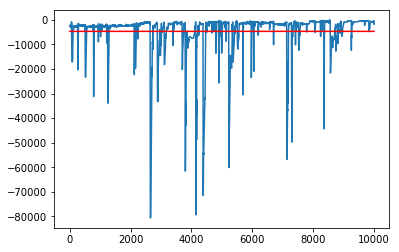

In [40]:
def plot_avg_1d(vec, title=None, xlabel=None, ylabel=None, save=False):
    record = np.array(vec)
    if len(record.shape) is not 1:
        print 'vec should be 1D array [e0, e1, ...]'
        return
    mu = record.mean(axis=0)
    plt.plot(xrange(record.shape[0]), record)
    plt.plot(xrange(record.shape[0]), mu*np.ones(record.shape[0]), color='red')
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}.png'.format(title))
    plt.show()

def plot_avg_2d(vec, title=None, xlabel=None, ylabel=None, save=False):
    record = np.array(vec)
    if len(record.shape) is not 2:
        print 'vec should be 2D array [[seq0], [seq1], ...]'
        return
    mu = record.mean(axis=0)
    sigma = record.std(axis=0)
    lower_bound = mu-sigma
    upper_bound = mu+sigma
    plt.plot(xrange(mu.shape[0]), mu, color='red')
    plt.fill_between(xrange(mu.shape[0]), lower_bound, upper_bound, facecolor='blue', alpha=0.5)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}.png'.format(title))
    plt.show()

n_vec_cost = np.array(n_vec_cost)
cost = gym_foa.envs.FoaEnv.Cost(*np.rollaxis(n_vec_cost,2))

total_cost = cost.collision[0]+cost.v_pref[0]+cost.goal[0]+cost.formation[0]
print cost.v_pref[0]
plot_avg_1d(cost.v_pref[0][int(9*1e+4):int(10*(1e+4))])

In [7]:
#torch.save(actor.state_dict(), 'actor.param')
#torch.save(critic.state_dict(), 'critic.param')

#from gym import wrappers

#env = wrappers.Monitor(env, 'exp', force=True)


actor = Actor()

print actor.state_dict()['fc1.bias'][1:10]

actor = torch.load('actor0.pt')

print actor['fc1.bias'][1:10]
            
for n in xrange(1):
    o = env.reset()
    actor = Actor().cuda()
    for t in xrange(MAX_STEP):
        print 'n:{}, t:{}'.format(n, t)
        env.render()
        a0 = choose_action(o[:N_STATES/N_UAVS], actor)
        #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
        #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
        #a = np.hstack([a0, a1, a2])
        
        print a0
        
        o_, r, done, info = env.step(a0)
    
        o = o_
        if done:
            break

[2017-09-25 16:01:25,766] Starting new video recorder writing to /home/linjt/foa/1024+1024_512_256,1024_1024_512_256/openaigym.video.0.12502.video000001.mp4



-0.1023
 0.0695
 0.3408
-0.0128
-0.0076
 0.2633
-0.2964
-0.2023
-0.0352
[torch.FloatTensor of size 9]


-0.1703
-0.3434
-0.1760
-0.1897
-0.0043
 0.0070
 0.0661
 0.0310
 0.2392
[torch.cuda.FloatTensor of size 9 (GPU 0)]

n:0, t:0
[ 0.3177824 -0.8932693]
n:0, t:1
[ 0.61214632 -1.56863058]
n:0, t:2
[ 0.58570939 -1.59654748]
n:0, t:3
[ 0.53044707 -1.60368454]


In [56]:
import pickle

# Saving the objects:
with open('objs.pickle', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(cost, f)

## Getting back the objects:
with open('objs.pickle') as f:  # Python 3: open(..., 'rb')
    k = pickle.load(f)
    
print cost

[ -3.40834796e+01  -1.92943304e+01  -1.00000000e+03  -5.29048693e-09]
